In [3]:
from __future__ import absolute_import, division, print_function

import pathlib

from astropy.io import fits
import matplotlib as m
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Conv1D
import tensorflow.keras.backend as K
print(tf.__version__)

from scipy.io import readsav
from scipy.signal import deconvolve

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0


In [4]:
font = 'Helvetica'
params = {'backend': 'tkagg',
          'axes.labelsize': 15,
          'axes.titlesize': 15,
          'font.size': 12,
          'legend.fontsize': 12,
          'font.family': 'sans-serif',
          'font.sans-serif': font,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'text.usetex': True,
          'figure.figsize': fig_size,
          'figure.dpi': 125,
          'lines.linewidth': 1.0,
          'axes.linewidth':1.0,
          'image.interpolation'  : 'nearest',
          'xtick.major.size'     : 5,      # major tick size in points
          'xtick.minor.size'     : 3.5,      # minor tick size in points
          'xtick.major.width'    : 0.5,    # major tick width in points
          'xtick.minor.width'    : 0.3,    # minor tick width in points
          'axes.spines.top': False,
          'axes.spines.right':False,
          'xtick.top': False,
          'ytick.right': False,
          'axes.formatter.useoffset': False
}
m.rcParams.update(params)
m.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]

m.rcParams['mathtext.fontset'] = 'custom'
m.rcParams['mathtext.rm'] = font
m.rcParams['mathtext.it'] = font+':italic'
m.rcParams['mathtext.bf'] = font+':bold'
m.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
fSizeAxisLabel = 10

NameError: name 'fig_size' is not defined

In [ ]:
print(weights)
def convolve(signal, filterProfile): 

    return np.convolve(signal, filterProfile)

def customLoss(yTrue, yPred):

    weights1 = K.constant(weights)
    return K.mean(K.square(yTrue - yPred) * weights1)

def customLoss1(yTrue, yPred):

    weights11 = K.constant(weights[0:40])
    return K.mean(K.square(yTrue - yPred) * weights11)

In [ ]:
def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    print(hdul.header)
    return spectrum 

def build_simple_model1():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  waveNumd  = 100
  model = keras.Sequential([
    layers.Conv1D(50, (3,),
        activation='relu',strides=1,input_shape=[waveNumd,1]),
    layers.Conv1D(40, (3,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(25, (3,),
        activation='relu'),
    layers.Conv1D(15, (4,),
        activation='relu'),
    layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(40,activation=tf.nn.relu),
    layers.Dense(40,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)


  model.compile(loss=customLoss,
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_conv_model():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  waveNumd  = dl
  model = keras.Sequential([
    layers.Conv1D(15, (3,),
        activation='relu', strides=1, input_shape=[waveNumd, 1]),
    layers.Conv1D(30, (5,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.Conv1D(25, (3,),
        activation='relu'),
    #layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    #layers.Dense(30,activation=tf.nn.relu),
    layers.Dense(30,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_conv_model2():
    #build the NN needed for the problem accomodating a single
    #convolutional layer and two densely connected hidden layer
    kSzConv1D = 3
    waveNumd  = dl
    y1 = layers.Input(shape=[dl,1])
    y = layers.Conv1D(5, (kSzConv1D, ), activation='relu')(y1)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(10, (kSzConv1D, ), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(20, (kSzConv1D, ), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    #y = layers.Dense(100,activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(20, (kSzConv1D, ), activation='relu')(y)
    #y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(10, (kSzConv1D, ), activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(5, (kSzConv1D, ), activation='relu')(y)
    #layers.GlobalAveragePooling1D(),
    #y = layers.Flatten()(y)
    #y = layers.Dropout(0.5)(y)
    y = layers.Flatten()(y)
    y = layers.Dense(waveNumd, activation=tf.nn.relu)(y)
    y2 = layers.Add()([y, y1[:,  :, 0]])
    y = layers.Dense(dl, activation=tf.nn.relu)(y2)

    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    
    x = layers.Dense(dl, activation='linear')(y2)
    optimizer = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=1.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss='mean_squared_error', optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

def build_conv_model_MP(ratio):
    #build the NN needed for the problem accomodating a single
    #convolutional layer and two densely connected hidden layer
    kSzConv1D = 3
    waveNumd  = 40
    
    y1 = layers.Input(shape=[waveNumd/ratio,1])
    y = layers.Conv1D(5,  (kSzConv1D,), activation='relu')(y1)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(10, (kSzConv1D,), activation='relu')(y)
    #y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(20, (kSzConv1D,), activation='relu')(y)
    #y = layers.MaxPooling1D(2)(y)
    #y = layers.Dense(100,activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(20,(kSzConv1D,), activation='relu')(y)
    y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(10,(kSzConv1D,), activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(5,(kSzConv1D,), activation='relu')(y)
    #layers.GlobalAveragePooling1D(),
    #y = layers.Flatten()(y)
    #y = layers.Dropout(0.5)(y)
    y = layers.Flatten()(y)
    y2 = layers.Dense(40,activation=tf.nn.relu)(y)
    #y2 = layers.Add()([y,y1[:,:,0]])
    #y = layers.Dense(40,activation=tf.nn.relu)(y2)

      #layers.GlobalAveragePooling1D(),
      #layers.Dense(20, activation='sigmoid'),    
      #layers.Dense(10, activation='sigmoid'),
    x = layers.Dense(40,activation='linear')(y2)
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model2 = keras.models.Model(inputs=y1, outputs=x)
    model2.compile(loss=customLoss1,
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    return model2

def build_dense_model():
    waveNumd  = 100
    numDense1 = 256
    y1 = layers.Input(shape=[waveNumd,1])
    y = layers.Flatten()(y1)
    y = layers.Dense(numDense1,activation='relu')(y)
    #y = layers.Dense(numDense1,activation='relu')(y)
    y = layers.Dense(numDense1,activation='relu')(y)
    y = layers.Dropout(0.2)(y)
    y = layers.Dense(numDense1,activation='relu')(y)
    y = layers.Dense(numDense1,activation='relu')(y)
    #y = layers.Dense(256,activation='relu')(y)
    #y = layers.Flatten()(y)
    y = layers.Dense(waveNumd,activation='sigmoid')(y)
    y = layers.Add()([y,y1[:,:,0]])
    x = layers.Dense(waveNumd,activation='linear')(y)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss=customLoss,
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model 


def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    return spectrum 

def radial_dist(sizeX,sizeY):
    '''Prepare a flat array of the radial distance of the pixel
    from the optical center of the system -- used for removing 
    uncorrected blueshifts
    '''
    
    centerX = sizeX/2
    centerY = sizeY/2
    
    radialDistances = np.zeros((sizeX,sizeY))
    
    for ii in range(sizeX):
        for jj in range(sizeY):
            radialDistances[ii,jj] = (centerX-ii)**2 + (centerY-jj)**2
    
    radialDistances = np.reshape(radialDistances,(sizeX*sizeY))
    
    return radialDistances


def prepare_data(spectrum):
    shape = spectrum.shape
    spec = np.reshape(spectrum,(shape[0],shape[1]*shape[2]))
    spec = np.swapaxes(spec,0,1)
    return spec

    
def plot_spec_profile_comparison(wavescale,profile_FP1,profile_FP2,profile_inferred):
    plt.figure(dpi=250,figsize=(8,6))
    #plt.style.use('ggplot')
    plt.plot(wavescale,profile_FP1,'g.--',label='Convolved spectrum')
    plt.plot(wavescale,profile_FP2,'b.--',label='Original spectrum')
    plt.plot(wavescale,profile_inferred,'k.--',label = 'Inferred spectrum')
    plt.legend()
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Wavelength, $\AA$')
    plt.grid(alpha=0.5)
    plt.savefig('Figures/Comparison_FISS.png',transparent=True)
    plt.show()


def Lorentzian(x0,x,gamma):
    x2  = (x0-x)*(x0-x)
    exp = gamma/(np.pi*(x2+gamma*gamma))
    return exp


def Gaussian(x,mu,sigma):
    return np.exp((-1)*(x-mu)*(x-mu)/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma)


def produce_FP_transmission_peak(dlambda,lambda_0,Nlambda,FPnum,wavelength):
    wave_I = np.linspace((lambda_0-dlambda*Nlambda/2),(lambda_0+dlambda*Nlambda/2),num=Nlambda)
    ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
    wave          = np.linspace(-24,24,num=48001)
    if wavelength == 6563:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_6563']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_6563'] 
    if wavelength == 8542:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_8542']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_8542']
    filterProfile = np.interp(wave_I,wave,t)
    return filterProfile

## Preview of some of the FISS data.

In [ ]:
haData = load_spectral_profiles('','FISS_20160622_174421_A1.fts')
haSpectralRes = 0.0190416632507
print('Shape of haData is %d %d %d'%haData.shape)
plt.imshow(haData[0,:,:])
plt.show()

plt.title('Average $H\\alpha$ profile')
plt.plot(np.mean(haData[:,:,:],axis=(0,1)), 'b.--', markersize=2)
plt.show()

caData = load_spectral_profiles('','FISS_20160622_175412_B1.fts')
caSpectralRes = 0.0256741359106
print('Shape of caData is %d %d %d'%caData.shape)
plt.imshow(caData[0,:,:])
plt.show()

plt.title('Average Ca II 8542 \AA~line')
plt.plot(np.mean(caData[:,:,:],axis=(0,1)), 'b.--', markersize=2)
plt.show()

## Convolve the FISS data with some PSFs

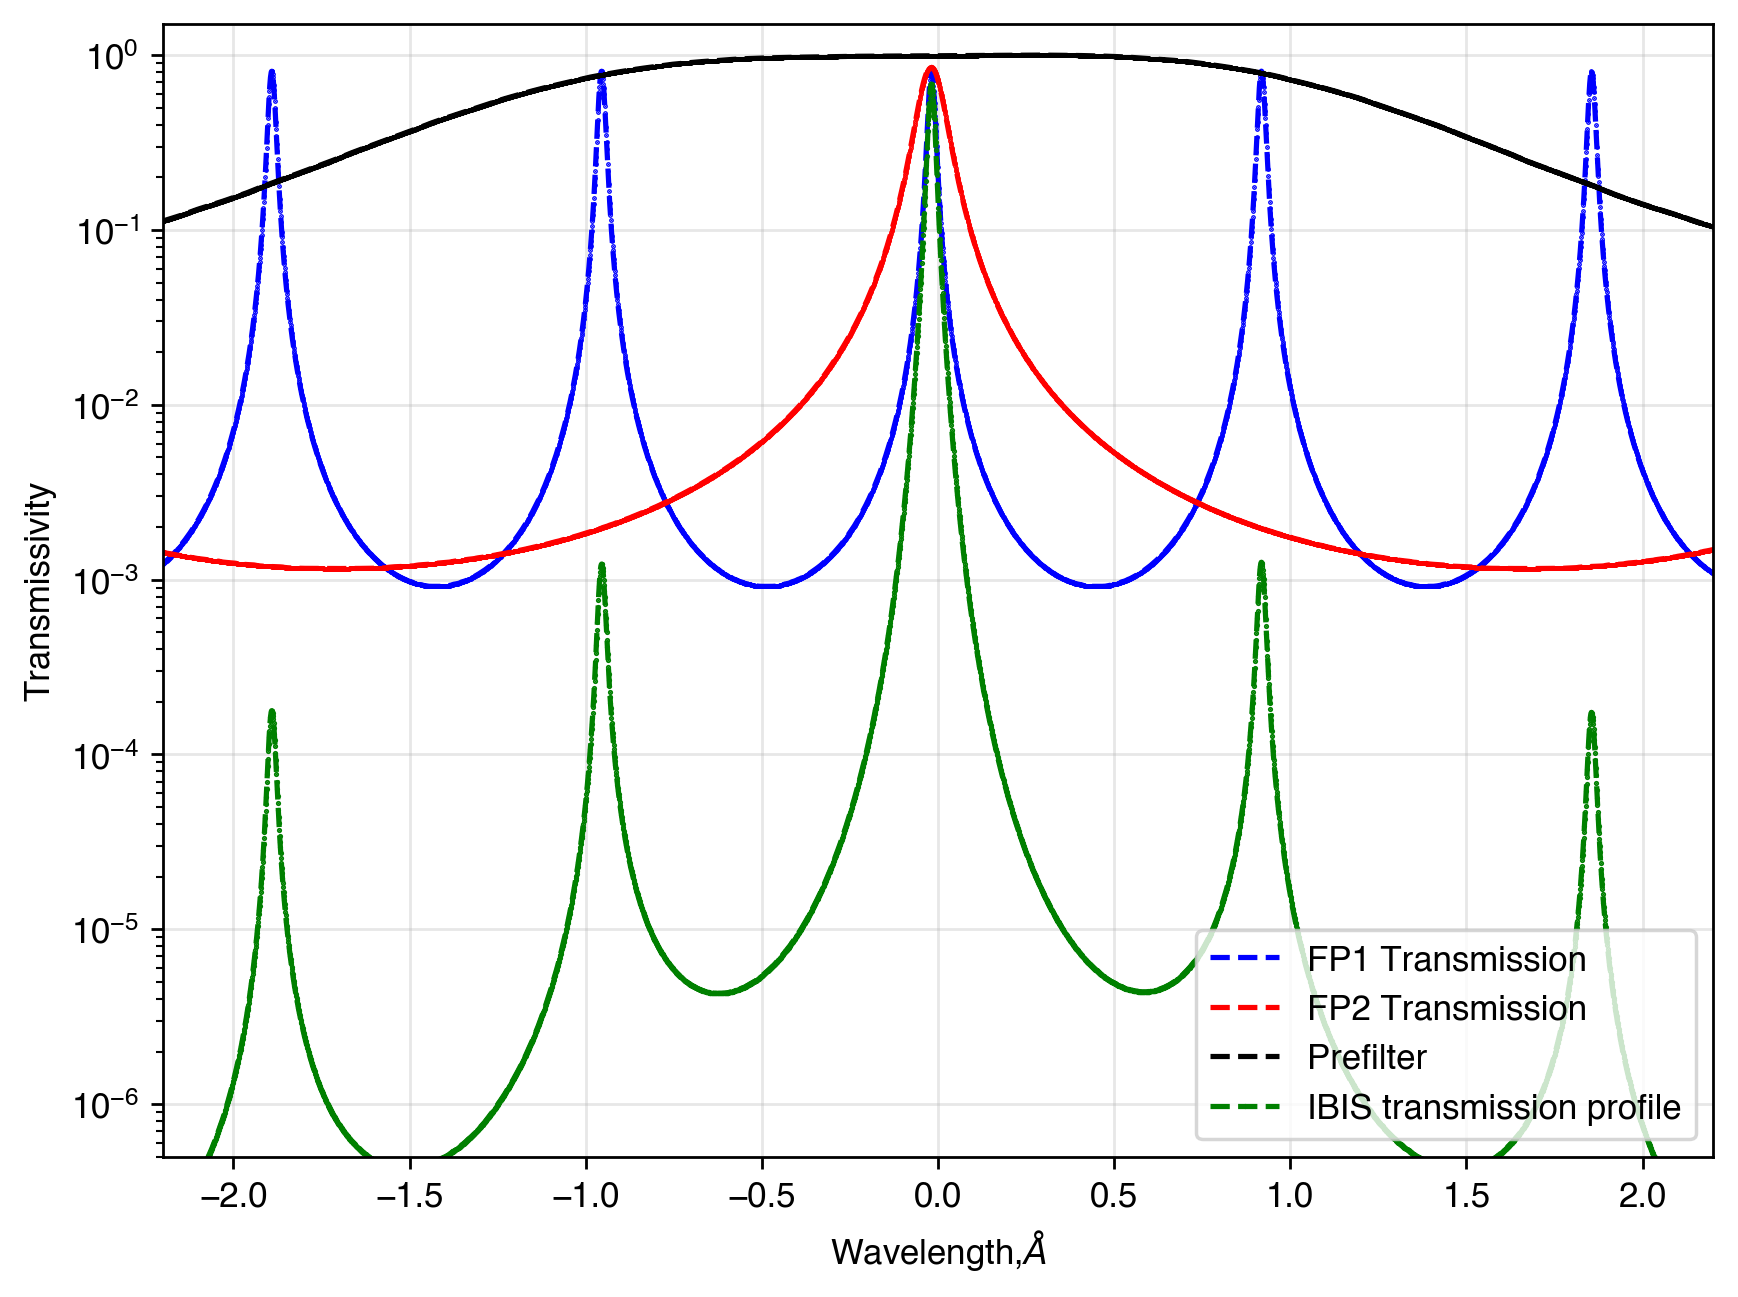

In [7]:
wave = np.linspace(-24,24,num=48001)
ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
pf = readsav('H-alpha_IBIS_Prefilter.sav')
pf_f = np.interp(wave,pf['PREFILT6563_REF_WVSCL'],pf['PREFILT6563_REF_MAIN'],left=0,right=0)
m.rcParams.update({'font.sans-serif':'Helvetica'})
csfont = {'fontname':'Helvetica'}
markersize1 = .75
plt.figure(figsize=(8,6),dpi=250)

plt.plot(wave,ab['ibis_fp1_profile_6563'],'b.--',label='FP1 Transmission',markersize=markersize1)
plt.plot(wave,ab['ibis_fp2_profile_6563'],'r.--',label='FP2 Transmission',markersize=markersize1)
plt.plot(wave,pf_f,'k.--',label='Prefilter',markersize=markersize1)
plt.plot(wave,ab['ibis_fp1_profile_6563']*ab['ibis_fp2_profile_6563']*pf_f,'g.--'
         ,markersize=1,label='IBIS transmission profile')
plt.legend()
plt.yscale('log')
plt.ylabel('Transmissivity',**csfont)
plt.ylim(5e-7,1.5)
plt.xlabel('Wavelength,$\\AA$',**csfont)
plt.xlim(-2.2,2.2)
plt.grid(alpha=0.3)
plt.savefig('Figures/FP_transmission_profile.png',transparent=True)
plt.show()

### Convolve the whole FISS FOV

NameError: name 'a' is not defined

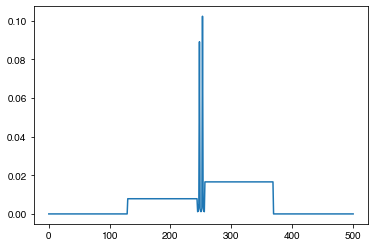

<Figure size 1200x800 with 0 Axes>

In [8]:
Nlambda      = 502
dlambda      = 0.024
trans_filter = produce_FP_transmission_peak(4,0,Nlambda,2,6563)
wave         = np.linspace(-.5*Nlambda*dlambda,.5*Nlambda*dlambda,num=Nlambda)

trans_filter[0:130] = 0
trans_filter[370:] = 0

trans_filter_total = np.sum(trans_filter)

plt.plot(trans_filter)
#plt.grid()
#plt.yscale('log')
#plt.show()
plt.figure(dpi=200)
b = np.convolve(a[0,0,:],trans_filter/trans_filter_total,mode='same')
print("Shape of b is %d"%b.shape)
print("Shape of a[0,0,:] is %d"%a[0,0,:].shape)
plt.plot(wave,(a[0,0,:]),'r.--',label='Genuine')
plt.plot(wave,(b[0:Nlambda]),'g.--',label='Convolved')
plt.legend()
plt.grid()
plt.show()

### Convolve the Ha and Ca data with the wide FP Transmission profile

502
(100, 250, 502)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


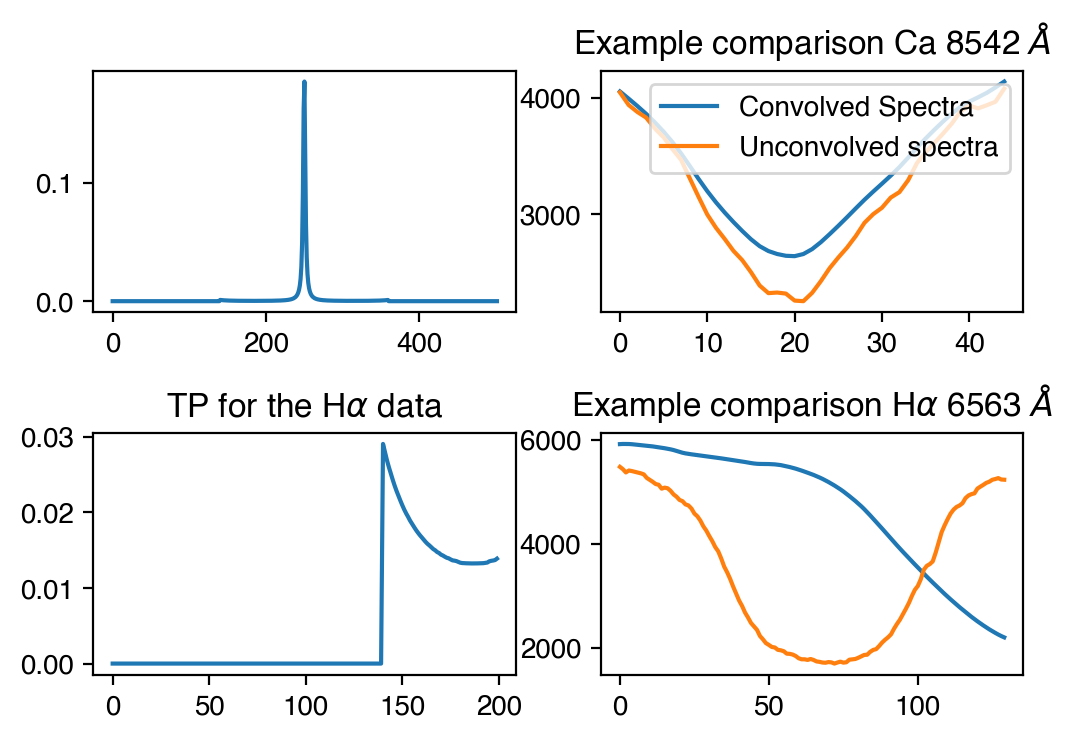

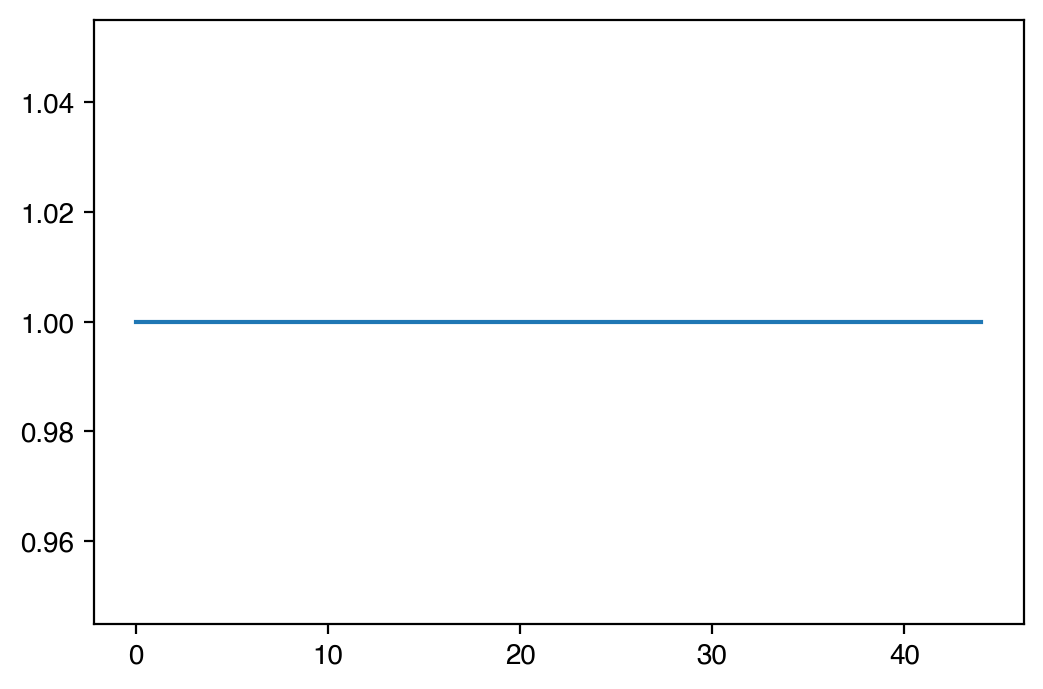

In [61]:
Nlambda_ca = caData.shape[2]
Nx_ca      = caData.shape[0]
Ny_ca      = caData.shape[1]

print(Nlambda_ca)
print(caData.shape)

lStart = 235
lEnd   = 280
dl     = lEnd - lStart

fig, ax = plt.subplots(nrows=2, ncols=2, dpi=200)
fig.subplots_adjust(hspace=.5)

TProfile = produce_FP_transmission_peak(caSpectralRes, 0, Nlambda_ca, 2, 6563)

TProfile[0:140] = 0
TProfile[360:] = 0
TProfile = TProfile / np.sum(TProfile)
ax[0, 0].plot(TProfile)

caConvolved = np.zeros((Nx_ca, Ny_ca, Nlambda_ca))

for ii in range(Nx_ca):
    for jj in range(Ny_ca):
        caConvolved[ii, jj, :] = np.convolve(caData[ii, jj, :], TProfile, mode='same')

ax[0,1].set_title('Example comparison Ca 8542 $\AA$')
ax[0,1].plot(caConvolved[80, 20, lStart:lEnd], label='Convolved Spectra')
ax[0,1].plot(caData[80, 20, lStart:lEnd], label='Unconvolved spectra')
ax[0,1].legend()

Nlambda_ha = haData.shape[2]
Nx_ha      = haData.shape[0]
Ny_ha      = haData.shape[1]


TProfile = produce_FP_transmission_peak(haSpectralRes,0,Nlambda,2,6563)

TProfile[0:140] = 0
TProfile[360:] = 0
TProfile = TProfile / np.sum(TProfile)


ax[1,0].plot(TProfile)
ax[1,0].set_title('TP for the H$\\alpha$ data')

haConvolved = np.zeros((Nx_ha,Ny_ha,Nlambda_ha))

for ii in range(Nx_ha):
    for jj in range(Ny_ha):
        haConvolved[ii,jj,:] = np.convolve(haData[ii,jj,:],TProfile,mode='same')

lStart_Ha = 170
lEnd_Ha   = 300
dl_Ha     = lEnd - lStart
ax[1, 1].set_title('Example comparison H$\\alpha$ 6563 $\AA$')
ax[1, 1].plot(haConvolved[80, 20, lStart_Ha:lEnd_Ha], label='Convolved spectra')
ax[1, 1].plot(haData[80, 20, lStart_Ha:lEnd_Ha], label='Unconvolved spectra')

fig.show()

fig1 = plt.figure(dpi=200)

mean_profile_8542 = (np.mean(np.mean(caData,axis=0),axis=0))[lStart:lEnd]

power_weigths     = 0
norm_const        = mean_profile_8542[0]**power_weigths
weights           = norm_const/mean_profile_8542**power_weigths

plt.plot(weights)
plt.show()

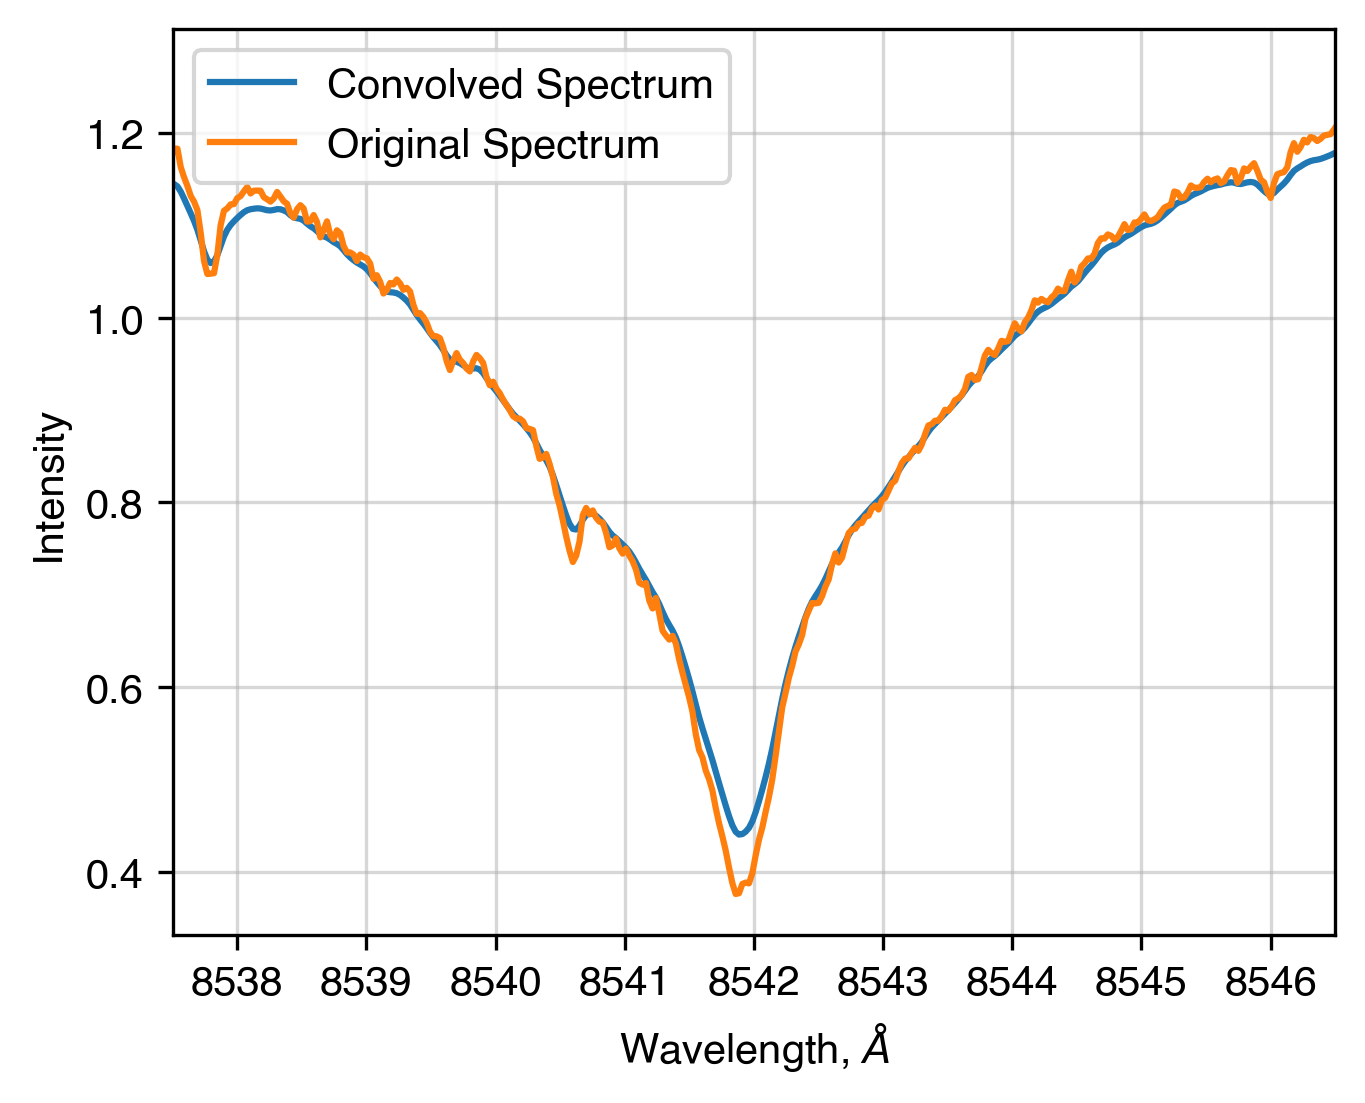

In [12]:
plt.figure(dpi=300,figsize=(5,4))
#plt.title('Example comparison Ca 8542 $\AA$')

norm   = 6000
m.rcParams.update({'font.sans-serif':'Helvetica'})
csfont = {'fontname':'Helvetica'}
wave   = np.linspace(caSpectralRes*502/2,caSpectralRes*502/(-2),num=502)+8542
plt.plot(wave,caConvolved[80,20,:]/norm,label='Convolved Spectrum')
plt.plot(wave,caData[80,20,:]/norm,label='Original Spectrum')
plt.xlabel('Wavelength, $\\AA$',**csfont)
plt.ylabel('Intensity',**csfont)
plt.xlim(8537.5,8546.5)
plt.grid(alpha=0.5)
plt.legend()
plt.savefig('Figures/CA_FISS_Example_conv11.png',transparent=True)
plt.show()

# Build and train the model

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 45, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 43, 5)        20          input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_12 (MaxPooling1D) (None, 21, 5)        0           conv1d_24[0][0]                  
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 19, 10)       160         max_pooling1d_12[0][0]           
____________________________________________________________________________________________

The normalization values for original are 5004.53232 and convolved images 5000.971318278386


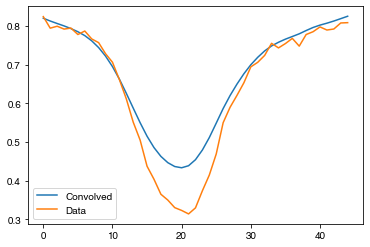

In [13]:
norm_data = np.mean(caData[:,:,200],axis=(0,1))
norm_conv = np.mean(caConvolved[:,:,200],axis=(0,1))
print(f'The normalization values for original are {norm_data} and convolved images {norm_conv}')

caData_Conv_norm = (caConvolved / norm_conv)[:,:,lStart:lEnd] 
caData_norm      = (caData / norm_conv)[:,:,lStart:lEnd] 
   
plt.plot(caData_Conv_norm[90,90,:], label='Convolved')
plt.plot(caData_norm[90,90,:], label='Data')
plt.legend()
plt.show()

In [68]:
model1 = build_conv_model2()
model1.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 45, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_54 (Conv1D)              (None, 43, 5)        20          input_10[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_27 (MaxPooling1D) (None, 21, 5)        0           conv1d_54[0][0]                  
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 19, 10)       160         max_pooling1d_27[0][0]           
____________________________________________________________________________________________

In [202]:
EPOCHS = 10000
optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    model1.optimizer = tf.keras.optimizers.Adam(lr=1e-1, beta_1=0.9,
              beta_2=0.999, epsilon=1e-8, decay=1.0, amsgrad=False)

if optimizer == 'SGD': 
    model1.optimizer = tf.keras.optimizers.SGD(lr=1, nesterov=True)

history = model1.fit(np.reshape(caData_Conv_norm, (int(Nx_ca * Ny_ca), dl, 1)),
                     np.reshape(caData_norm, (int(Nx_ca * Ny_ca), dl)),
                     epochs=EPOCHS, validation_split=0.20, verbose=2)

'''
history = model.fit(np.reshape(caData_Conv_norm[:,:,lStart:lEnd],(int(Nx_ca*Ny_ca),dl,1)),
                    np.reshape(caData_norm[:,:,lStart:lEnd],(int(Nx_ca*Ny_ca),dl)),
                    epochs=EPOCHS,validation_split=0.25 , verbose=2)
'''

Train on 20000 samples, validate on 5000 samples
Epoch 1/10000
20000/20000 - 3s - loss: 1.6438e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6438e-04 - val_loss: 1.8553e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8553e-04
Epoch 2/10000
20000/20000 - 3s - loss: 1.6438e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6438e-04 - val_loss: 1.8553e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8553e-04
Epoch 3/10000
20000/20000 - 3s - loss: 1.6438e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6438e-04 - val_loss: 1.8553e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8553e-04
Epoch 4/10000
20000/20000 - 3s - loss: 1.6438e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6438e-04 - val_loss: 1.8553e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8553e-04
Epoch 5/10000
20000/20000 - 3s - loss: 1.6438e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6438e-04 - val_loss

Epoch 41/10000
20000/20000 - 3s - loss: 1.6436e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6436e-04 - val_loss: 1.8550e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8550e-04
Epoch 42/10000
20000/20000 - 3s - loss: 1.6436e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6436e-04 - val_loss: 1.8550e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8550e-04
Epoch 43/10000
20000/20000 - 3s - loss: 1.6436e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6436e-04 - val_loss: 1.8550e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8550e-04
Epoch 44/10000
20000/20000 - 3s - loss: 1.6436e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6436e-04 - val_loss: 1.8550e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8550e-04
Epoch 45/10000
20000/20000 - 3s - loss: 1.6436e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6436e-04 - val_loss: 1.8550e-04 - val_mean_absolute_error: 0.01

Epoch 81/10000
20000/20000 - 3s - loss: 1.6434e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6434e-04 - val_loss: 1.8548e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8548e-04
Epoch 82/10000
20000/20000 - 3s - loss: 1.6434e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6434e-04 - val_loss: 1.8548e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8548e-04
Epoch 83/10000
20000/20000 - 3s - loss: 1.6434e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6434e-04 - val_loss: 1.8548e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8548e-04
Epoch 84/10000
20000/20000 - 3s - loss: 1.6434e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6434e-04 - val_loss: 1.8548e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8548e-04
Epoch 85/10000
20000/20000 - 3s - loss: 1.6434e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6434e-04 - val_loss: 1.8547e-04 - val_mean_absolute_error: 0.01

Epoch 121/10000
20000/20000 - 3s - loss: 1.6432e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6433e-04 - val_loss: 1.8545e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8545e-04
Epoch 122/10000
20000/20000 - 3s - loss: 1.6432e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6432e-04 - val_loss: 1.8545e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8545e-04
Epoch 123/10000
20000/20000 - 3s - loss: 1.6432e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6432e-04 - val_loss: 1.8545e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8545e-04
Epoch 124/10000
20000/20000 - 3s - loss: 1.6432e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6432e-04 - val_loss: 1.8545e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8545e-04
Epoch 125/10000
20000/20000 - 3s - loss: 1.6432e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6432e-04 - val_loss: 1.8545e-04 - val_mean_absolute_error:

Epoch 161/10000
20000/20000 - 3s - loss: 1.6431e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6431e-04 - val_loss: 1.8542e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8542e-04
Epoch 162/10000
20000/20000 - 3s - loss: 1.6430e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6430e-04 - val_loss: 1.8542e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8542e-04
Epoch 163/10000
20000/20000 - 3s - loss: 1.6430e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6430e-04 - val_loss: 1.8542e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8542e-04
Epoch 164/10000
20000/20000 - 3s - loss: 1.6430e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6430e-04 - val_loss: 1.8542e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8542e-04
Epoch 165/10000
20000/20000 - 3s - loss: 1.6430e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6430e-04 - val_loss: 1.8542e-04 - val_mean_absolute_error:

Epoch 201/10000
20000/20000 - 3s - loss: 1.6429e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6429e-04 - val_loss: 1.8540e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8540e-04
Epoch 202/10000
20000/20000 - 3s - loss: 1.6429e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6429e-04 - val_loss: 1.8540e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8540e-04
Epoch 203/10000
20000/20000 - 3s - loss: 1.6428e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6428e-04 - val_loss: 1.8540e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8540e-04
Epoch 204/10000
20000/20000 - 3s - loss: 1.6428e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6428e-04 - val_loss: 1.8540e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8540e-04
Epoch 205/10000
20000/20000 - 3s - loss: 1.6428e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6428e-04 - val_loss: 1.8540e-04 - val_mean_absolute_error:

Epoch 241/10000
20000/20000 - 3s - loss: 1.6427e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6427e-04 - val_loss: 1.8537e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8537e-04
Epoch 242/10000
20000/20000 - 3s - loss: 1.6427e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6427e-04 - val_loss: 1.8537e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8537e-04
Epoch 243/10000
20000/20000 - 3s - loss: 1.6427e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6427e-04 - val_loss: 1.8537e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8537e-04
Epoch 244/10000
20000/20000 - 3s - loss: 1.6427e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6427e-04 - val_loss: 1.8537e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8537e-04
Epoch 245/10000
20000/20000 - 3s - loss: 1.6426e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6426e-04 - val_loss: 1.8537e-04 - val_mean_absolute_error:

Epoch 281/10000
20000/20000 - 3s - loss: 1.6425e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6425e-04 - val_loss: 1.8535e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8535e-04
Epoch 282/10000
20000/20000 - 3s - loss: 1.6425e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6425e-04 - val_loss: 1.8535e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8535e-04
Epoch 283/10000
20000/20000 - 3s - loss: 1.6425e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6425e-04 - val_loss: 1.8534e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8534e-04
Epoch 284/10000
20000/20000 - 3s - loss: 1.6425e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6425e-04 - val_loss: 1.8534e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8534e-04
Epoch 285/10000
20000/20000 - 3s - loss: 1.6425e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6424e-04 - val_loss: 1.8534e-04 - val_mean_absolute_error:

Epoch 321/10000
20000/20000 - 3s - loss: 1.6423e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6423e-04 - val_loss: 1.8532e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8532e-04
Epoch 322/10000
20000/20000 - 3s - loss: 1.6423e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6423e-04 - val_loss: 1.8532e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8532e-04
Epoch 323/10000
20000/20000 - 3s - loss: 1.6423e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6423e-04 - val_loss: 1.8532e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8532e-04
Epoch 324/10000
20000/20000 - 3s - loss: 1.6423e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6423e-04 - val_loss: 1.8532e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8532e-04
Epoch 325/10000
20000/20000 - 3s - loss: 1.6423e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6423e-04 - val_loss: 1.8532e-04 - val_mean_absolute_error:

Epoch 361/10000
20000/20000 - 3s - loss: 1.6421e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6421e-04 - val_loss: 1.8529e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8529e-04
Epoch 362/10000
20000/20000 - 3s - loss: 1.6421e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6421e-04 - val_loss: 1.8529e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8529e-04
Epoch 363/10000
20000/20000 - 3s - loss: 1.6421e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6421e-04 - val_loss: 1.8529e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8529e-04
Epoch 364/10000
20000/20000 - 3s - loss: 1.6421e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6421e-04 - val_loss: 1.8529e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8529e-04
Epoch 365/10000
20000/20000 - 3s - loss: 1.6421e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6421e-04 - val_loss: 1.8529e-04 - val_mean_absolute_error:

Epoch 401/10000
20000/20000 - 4s - loss: 1.6419e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6419e-04 - val_loss: 1.8527e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8527e-04
Epoch 402/10000
20000/20000 - 3s - loss: 1.6419e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6419e-04 - val_loss: 1.8527e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8527e-04
Epoch 403/10000
20000/20000 - 3s - loss: 1.6419e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6419e-04 - val_loss: 1.8527e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8527e-04
Epoch 404/10000
20000/20000 - 3s - loss: 1.6419e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6419e-04 - val_loss: 1.8527e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8527e-04
Epoch 405/10000
20000/20000 - 4s - loss: 1.6419e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6419e-04 - val_loss: 1.8527e-04 - val_mean_absolute_error:

Epoch 441/10000
20000/20000 - 3s - loss: 1.6417e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6417e-04 - val_loss: 1.8524e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8524e-04
Epoch 442/10000
20000/20000 - 3s - loss: 1.6417e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6417e-04 - val_loss: 1.8524e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8524e-04
Epoch 443/10000
20000/20000 - 3s - loss: 1.6417e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6417e-04 - val_loss: 1.8524e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8524e-04
Epoch 444/10000
20000/20000 - 4s - loss: 1.6417e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6417e-04 - val_loss: 1.8524e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8524e-04
Epoch 445/10000
20000/20000 - 4s - loss: 1.6417e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6417e-04 - val_loss: 1.8524e-04 - val_mean_absolute_error:

Epoch 481/10000
20000/20000 - 3s - loss: 1.6415e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6415e-04 - val_loss: 1.8522e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8522e-04
Epoch 482/10000
20000/20000 - 3s - loss: 1.6415e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6415e-04 - val_loss: 1.8522e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8522e-04
Epoch 483/10000
20000/20000 - 3s - loss: 1.6415e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6415e-04 - val_loss: 1.8522e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8522e-04
Epoch 484/10000
20000/20000 - 3s - loss: 1.6415e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6415e-04 - val_loss: 1.8521e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8521e-04
Epoch 485/10000
20000/20000 - 3s - loss: 1.6415e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6415e-04 - val_loss: 1.8521e-04 - val_mean_absolute_error:

Epoch 521/10000
20000/20000 - 3s - loss: 1.6413e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6413e-04 - val_loss: 1.8519e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8519e-04
Epoch 522/10000
20000/20000 - 3s - loss: 1.6413e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6413e-04 - val_loss: 1.8519e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8519e-04
Epoch 523/10000
20000/20000 - 3s - loss: 1.6413e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6413e-04 - val_loss: 1.8519e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8519e-04
Epoch 524/10000
20000/20000 - 3s - loss: 1.6413e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6413e-04 - val_loss: 1.8519e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8519e-04
Epoch 525/10000
20000/20000 - 3s - loss: 1.6413e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6413e-04 - val_loss: 1.8519e-04 - val_mean_absolute_error:

Epoch 561/10000
20000/20000 - 3s - loss: 1.6411e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6411e-04 - val_loss: 1.8517e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8517e-04
Epoch 562/10000
20000/20000 - 3s - loss: 1.6411e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6411e-04 - val_loss: 1.8517e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8517e-04
Epoch 563/10000
20000/20000 - 3s - loss: 1.6411e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6411e-04 - val_loss: 1.8516e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8516e-04
Epoch 564/10000
20000/20000 - 3s - loss: 1.6411e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6411e-04 - val_loss: 1.8516e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8516e-04
Epoch 565/10000
20000/20000 - 3s - loss: 1.6411e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6411e-04 - val_loss: 1.8516e-04 - val_mean_absolute_error:

Epoch 601/10000
20000/20000 - 3s - loss: 1.6410e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6410e-04 - val_loss: 1.8514e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8514e-04
Epoch 602/10000
20000/20000 - 3s - loss: 1.6410e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6410e-04 - val_loss: 1.8514e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8514e-04
Epoch 603/10000
20000/20000 - 3s - loss: 1.6409e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6409e-04 - val_loss: 1.8514e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8514e-04
Epoch 604/10000
20000/20000 - 3s - loss: 1.6409e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6409e-04 - val_loss: 1.8514e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8514e-04
Epoch 605/10000
20000/20000 - 3s - loss: 1.6409e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6409e-04 - val_loss: 1.8514e-04 - val_mean_absolute_error:

Epoch 641/10000
20000/20000 - 4s - loss: 1.6408e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6408e-04 - val_loss: 1.8512e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8512e-04
Epoch 642/10000
20000/20000 - 3s - loss: 1.6408e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6408e-04 - val_loss: 1.8512e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8512e-04
Epoch 643/10000
20000/20000 - 3s - loss: 1.6408e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6408e-04 - val_loss: 1.8512e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8512e-04
Epoch 644/10000
20000/20000 - 3s - loss: 1.6408e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6408e-04 - val_loss: 1.8511e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8511e-04
Epoch 645/10000
20000/20000 - 3s - loss: 1.6408e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6408e-04 - val_loss: 1.8511e-04 - val_mean_absolute_error:

Epoch 681/10000
20000/20000 - 3s - loss: 1.6406e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6406e-04 - val_loss: 1.8509e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8509e-04
Epoch 682/10000
20000/20000 - 3s - loss: 1.6406e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6406e-04 - val_loss: 1.8509e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8509e-04
Epoch 683/10000
20000/20000 - 3s - loss: 1.6406e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6406e-04 - val_loss: 1.8509e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8509e-04
Epoch 684/10000
20000/20000 - 3s - loss: 1.6406e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6406e-04 - val_loss: 1.8509e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8509e-04
Epoch 685/10000
20000/20000 - 3s - loss: 1.6406e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6406e-04 - val_loss: 1.8509e-04 - val_mean_absolute_error:

Epoch 721/10000
20000/20000 - 3s - loss: 1.6404e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6404e-04 - val_loss: 1.8507e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8507e-04
Epoch 722/10000
20000/20000 - 3s - loss: 1.6404e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6404e-04 - val_loss: 1.8507e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8507e-04
Epoch 723/10000
20000/20000 - 3s - loss: 1.6404e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6404e-04 - val_loss: 1.8507e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8507e-04
Epoch 724/10000
20000/20000 - 3s - loss: 1.6404e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6404e-04 - val_loss: 1.8507e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8507e-04
Epoch 725/10000
20000/20000 - 4s - loss: 1.6404e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6404e-04 - val_loss: 1.8507e-04 - val_mean_absolute_error:

Epoch 761/10000
20000/20000 - 3s - loss: 1.6402e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6402e-04 - val_loss: 1.8505e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8505e-04
Epoch 762/10000
20000/20000 - 3s - loss: 1.6402e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6402e-04 - val_loss: 1.8505e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8505e-04
Epoch 763/10000
20000/20000 - 3s - loss: 1.6402e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6402e-04 - val_loss: 1.8504e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8504e-04
Epoch 764/10000
20000/20000 - 3s - loss: 1.6402e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6402e-04 - val_loss: 1.8504e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8504e-04
Epoch 765/10000
20000/20000 - 3s - loss: 1.6402e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6402e-04 - val_loss: 1.8504e-04 - val_mean_absolute_error:

Epoch 801/10000
20000/20000 - 3s - loss: 1.6400e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6400e-04 - val_loss: 1.8502e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8502e-04
Epoch 802/10000
20000/20000 - 4s - loss: 1.6400e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6400e-04 - val_loss: 1.8502e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8502e-04
Epoch 803/10000
20000/20000 - 4s - loss: 1.6400e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6400e-04 - val_loss: 1.8502e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8502e-04
Epoch 804/10000
20000/20000 - 3s - loss: 1.6400e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6400e-04 - val_loss: 1.8502e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8502e-04
Epoch 805/10000
20000/20000 - 3s - loss: 1.6400e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6400e-04 - val_loss: 1.8502e-04 - val_mean_absolute_error:

Epoch 841/10000
20000/20000 - 3s - loss: 1.6399e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6399e-04 - val_loss: 1.8500e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8500e-04
Epoch 842/10000
20000/20000 - 3s - loss: 1.6399e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6399e-04 - val_loss: 1.8500e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8500e-04
Epoch 843/10000
20000/20000 - 3s - loss: 1.6398e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6398e-04 - val_loss: 1.8500e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8500e-04
Epoch 844/10000
20000/20000 - 3s - loss: 1.6398e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6398e-04 - val_loss: 1.8499e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8499e-04
Epoch 845/10000
20000/20000 - 3s - loss: 1.6398e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6398e-04 - val_loss: 1.8499e-04 - val_mean_absolute_error:

Epoch 881/10000
20000/20000 - 3s - loss: 1.6397e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6397e-04 - val_loss: 1.8497e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8497e-04
Epoch 882/10000
20000/20000 - 3s - loss: 1.6397e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6397e-04 - val_loss: 1.8497e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8497e-04
Epoch 883/10000
20000/20000 - 3s - loss: 1.6397e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6397e-04 - val_loss: 1.8497e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8497e-04
Epoch 884/10000
20000/20000 - 3s - loss: 1.6397e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6397e-04 - val_loss: 1.8497e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8497e-04
Epoch 885/10000
20000/20000 - 3s - loss: 1.6397e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6397e-04 - val_loss: 1.8497e-04 - val_mean_absolute_error:

Epoch 921/10000
20000/20000 - 3s - loss: 1.6395e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6395e-04 - val_loss: 1.8495e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8495e-04
Epoch 922/10000
20000/20000 - 4s - loss: 1.6395e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6395e-04 - val_loss: 1.8495e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8495e-04
Epoch 923/10000
20000/20000 - 3s - loss: 1.6395e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6395e-04 - val_loss: 1.8495e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8495e-04
Epoch 924/10000
20000/20000 - 3s - loss: 1.6395e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6395e-04 - val_loss: 1.8495e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8495e-04
Epoch 925/10000
20000/20000 - 3s - loss: 1.6395e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6395e-04 - val_loss: 1.8494e-04 - val_mean_absolute_error:

Epoch 961/10000
20000/20000 - 3s - loss: 1.6393e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6393e-04 - val_loss: 1.8492e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8492e-04
Epoch 962/10000
20000/20000 - 3s - loss: 1.6393e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6393e-04 - val_loss: 1.8492e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8492e-04
Epoch 963/10000
20000/20000 - 3s - loss: 1.6393e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6393e-04 - val_loss: 1.8492e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8492e-04
Epoch 964/10000
20000/20000 - 3s - loss: 1.6393e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6393e-04 - val_loss: 1.8492e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8492e-04
Epoch 965/10000
20000/20000 - 3s - loss: 1.6393e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6393e-04 - val_loss: 1.8492e-04 - val_mean_absolute_error:

Epoch 1001/10000
20000/20000 - 3s - loss: 1.6391e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6391e-04 - val_loss: 1.8490e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8490e-04
Epoch 1002/10000
20000/20000 - 3s - loss: 1.6391e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6391e-04 - val_loss: 1.8490e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8490e-04
Epoch 1003/10000
20000/20000 - 3s - loss: 1.6391e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6391e-04 - val_loss: 1.8490e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8490e-04
Epoch 1004/10000
20000/20000 - 3s - loss: 1.6391e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6391e-04 - val_loss: 1.8490e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8490e-04
Epoch 1005/10000
20000/20000 - 3s - loss: 1.6391e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6391e-04 - val_loss: 1.8490e-04 - val_mean_absolute_e

20000/20000 - 4s - loss: 1.6390e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6390e-04 - val_loss: 1.8487e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8487e-04
Epoch 1041/10000
20000/20000 - 4s - loss: 1.6390e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6390e-04 - val_loss: 1.8487e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8487e-04
Epoch 1042/10000
20000/20000 - 4s - loss: 1.6390e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6390e-04 - val_loss: 1.8487e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8487e-04
Epoch 1043/10000
20000/20000 - 4s - loss: 1.6390e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6390e-04 - val_loss: 1.8487e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8487e-04
Epoch 1044/10000
20000/20000 - 4s - loss: 1.6390e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6390e-04 - val_loss: 1.8487e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 1080/10000
20000/20000 - 4s - loss: 1.6388e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6388e-04 - val_loss: 1.8485e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8485e-04
Epoch 1081/10000
20000/20000 - 3s - loss: 1.6388e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6388e-04 - val_loss: 1.8485e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8485e-04
Epoch 1082/10000
20000/20000 - 4s - loss: 1.6388e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6388e-04 - val_loss: 1.8485e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8485e-04
Epoch 1083/10000
20000/20000 - 3s - loss: 1.6388e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6388e-04 - val_loss: 1.8485e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8485e-04
Epoch 1084/10000
20000/20000 - 3s - loss: 1.6388e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6388e-04 - val_loss: 1.8485e-04 - val_mean_absolute_e

20000/20000 - 4s - loss: 1.6386e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6386e-04 - val_loss: 1.8483e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8483e-04
Epoch 1120/10000
20000/20000 - 3s - loss: 1.6386e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6386e-04 - val_loss: 1.8483e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8483e-04
Epoch 1121/10000
20000/20000 - 3s - loss: 1.6386e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6386e-04 - val_loss: 1.8483e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8483e-04
Epoch 1122/10000
20000/20000 - 3s - loss: 1.6386e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6386e-04 - val_loss: 1.8483e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8483e-04
Epoch 1123/10000
20000/20000 - 3s - loss: 1.6386e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6386e-04 - val_loss: 1.8483e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 1159/10000
20000/20000 - 4s - loss: 1.6384e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6384e-04 - val_loss: 1.8481e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8481e-04
Epoch 1160/10000
20000/20000 - 3s - loss: 1.6384e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6384e-04 - val_loss: 1.8481e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8481e-04
Epoch 1161/10000
20000/20000 - 3s - loss: 1.6384e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6384e-04 - val_loss: 1.8481e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8481e-04
Epoch 1162/10000
20000/20000 - 3s - loss: 1.6384e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6384e-04 - val_loss: 1.8481e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8481e-04
Epoch 1163/10000
20000/20000 - 4s - loss: 1.6384e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6384e-04 - val_loss: 1.8480e-04 - val_mean_absolute_e

20000/20000 - 3s - loss: 1.6383e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6383e-04 - val_loss: 1.8479e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8479e-04
Epoch 1199/10000
20000/20000 - 3s - loss: 1.6383e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6383e-04 - val_loss: 1.8479e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8479e-04
Epoch 1200/10000
20000/20000 - 3s - loss: 1.6383e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6383e-04 - val_loss: 1.8478e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8478e-04
Epoch 1201/10000
20000/20000 - 3s - loss: 1.6383e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6383e-04 - val_loss: 1.8479e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8479e-04
Epoch 1202/10000
20000/20000 - 3s - loss: 1.6383e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6383e-04 - val_loss: 1.8478e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 1238/10000
20000/20000 - 3s - loss: 1.6381e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6381e-04 - val_loss: 1.8476e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8476e-04
Epoch 1239/10000
20000/20000 - 3s - loss: 1.6381e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6381e-04 - val_loss: 1.8476e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8476e-04
Epoch 1240/10000
20000/20000 - 4s - loss: 1.6381e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6381e-04 - val_loss: 1.8476e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8476e-04
Epoch 1241/10000
20000/20000 - 4s - loss: 1.6381e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6381e-04 - val_loss: 1.8476e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8476e-04
Epoch 1242/10000
20000/20000 - 3s - loss: 1.6381e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6381e-04 - val_loss: 1.8476e-04 - val_mean_absolute_e

20000/20000 - 4s - loss: 1.6379e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6379e-04 - val_loss: 1.8474e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8474e-04
Epoch 1278/10000
20000/20000 - 4s - loss: 1.6379e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6379e-04 - val_loss: 1.8474e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8474e-04
Epoch 1279/10000
20000/20000 - 4s - loss: 1.6379e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6379e-04 - val_loss: 1.8474e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8473e-04
Epoch 1280/10000
20000/20000 - 3s - loss: 1.6379e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6379e-04 - val_loss: 1.8473e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8473e-04
Epoch 1281/10000
20000/20000 - 3s - loss: 1.6379e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6379e-04 - val_loss: 1.8473e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 1317/10000
20000/20000 - 3s - loss: 1.6378e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6378e-04 - val_loss: 1.8472e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8472e-04
Epoch 1318/10000
20000/20000 - 3s - loss: 1.6378e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6378e-04 - val_loss: 1.8471e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8471e-04
Epoch 1319/10000
20000/20000 - 3s - loss: 1.6378e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6378e-04 - val_loss: 1.8471e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8471e-04
Epoch 1320/10000
20000/20000 - 3s - loss: 1.6378e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6378e-04 - val_loss: 1.8471e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8471e-04
Epoch 1321/10000
20000/20000 - 3s - loss: 1.6377e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6377e-04 - val_loss: 1.8471e-04 - val_mean_absolute_e

20000/20000 - 3s - loss: 1.6376e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6376e-04 - val_loss: 1.8469e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8469e-04
Epoch 1357/10000
20000/20000 - 3s - loss: 1.6376e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6376e-04 - val_loss: 1.8469e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8469e-04
Epoch 1358/10000
20000/20000 - 3s - loss: 1.6376e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6376e-04 - val_loss: 1.8469e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8469e-04
Epoch 1359/10000
20000/20000 - 3s - loss: 1.6376e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6376e-04 - val_loss: 1.8469e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8469e-04
Epoch 1360/10000
20000/20000 - 3s - loss: 1.6376e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6376e-04 - val_loss: 1.8469e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 1396/10000
20000/20000 - 3s - loss: 1.6374e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6374e-04 - val_loss: 1.8467e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8467e-04
Epoch 1397/10000
20000/20000 - 3s - loss: 1.6374e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6374e-04 - val_loss: 1.8467e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8467e-04
Epoch 1398/10000
20000/20000 - 3s - loss: 1.6374e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6374e-04 - val_loss: 1.8467e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8467e-04
Epoch 1399/10000
20000/20000 - 3s - loss: 1.6374e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6374e-04 - val_loss: 1.8467e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8467e-04
Epoch 1400/10000
20000/20000 - 3s - loss: 1.6374e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6374e-04 - val_loss: 1.8467e-04 - val_mean_absolute_e

20000/20000 - 4s - loss: 1.6373e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6373e-04 - val_loss: 1.8465e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8465e-04
Epoch 1436/10000
20000/20000 - 4s - loss: 1.6373e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6373e-04 - val_loss: 1.8465e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8465e-04
Epoch 1437/10000
20000/20000 - 3s - loss: 1.6373e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6373e-04 - val_loss: 1.8465e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8465e-04
Epoch 1438/10000
20000/20000 - 3s - loss: 1.6373e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6373e-04 - val_loss: 1.8465e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8465e-04
Epoch 1439/10000
20000/20000 - 3s - loss: 1.6372e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6372e-04 - val_loss: 1.8465e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 1475/10000
20000/20000 - 3s - loss: 1.6371e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6371e-04 - val_loss: 1.8463e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8463e-04
Epoch 1476/10000
20000/20000 - 3s - loss: 1.6371e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6371e-04 - val_loss: 1.8463e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8463e-04
Epoch 1477/10000
20000/20000 - 3s - loss: 1.6371e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6371e-04 - val_loss: 1.8463e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8463e-04
Epoch 1478/10000
20000/20000 - 3s - loss: 1.6371e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6371e-04 - val_loss: 1.8462e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8462e-04
Epoch 1479/10000
20000/20000 - 3s - loss: 1.6371e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6371e-04 - val_loss: 1.8462e-04 - val_mean_absolute_e

20000/20000 - 3s - loss: 1.6369e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6369e-04 - val_loss: 1.8460e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8460e-04
Epoch 1515/10000
20000/20000 - 3s - loss: 1.6369e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6369e-04 - val_loss: 1.8460e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8460e-04
Epoch 1516/10000
20000/20000 - 3s - loss: 1.6369e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6369e-04 - val_loss: 1.8460e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8460e-04
Epoch 1517/10000
20000/20000 - 3s - loss: 1.6369e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6369e-04 - val_loss: 1.8460e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8460e-04
Epoch 1518/10000
20000/20000 - 3s - loss: 1.6369e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6369e-04 - val_loss: 1.8460e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 1554/10000
20000/20000 - 4s - loss: 1.6368e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6368e-04 - val_loss: 1.8458e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8458e-04
Epoch 1555/10000
20000/20000 - 4s - loss: 1.6368e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6368e-04 - val_loss: 1.8458e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8458e-04
Epoch 1556/10000
20000/20000 - 4s - loss: 1.6368e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6368e-04 - val_loss: 1.8458e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8458e-04
Epoch 1557/10000
20000/20000 - 4s - loss: 1.6368e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6368e-04 - val_loss: 1.8458e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8458e-04
Epoch 1558/10000
20000/20000 - 4s - loss: 1.6368e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6368e-04 - val_loss: 1.8458e-04 - val_mean_absolute_e

20000/20000 - 3s - loss: 1.6366e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6366e-04 - val_loss: 1.8456e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8456e-04
Epoch 1594/10000
20000/20000 - 3s - loss: 1.6366e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6366e-04 - val_loss: 1.8456e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8456e-04
Epoch 1595/10000
20000/20000 - 3s - loss: 1.6366e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6366e-04 - val_loss: 1.8456e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8456e-04
Epoch 1596/10000
20000/20000 - 3s - loss: 1.6366e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6366e-04 - val_loss: 1.8456e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8456e-04
Epoch 1597/10000
20000/20000 - 4s - loss: 1.6366e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6366e-04 - val_loss: 1.8456e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 1633/10000
20000/20000 - 3s - loss: 1.6364e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6364e-04 - val_loss: 1.8454e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8454e-04
Epoch 1634/10000
20000/20000 - 3s - loss: 1.6364e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6364e-04 - val_loss: 1.8454e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8454e-04
Epoch 1635/10000
20000/20000 - 3s - loss: 1.6364e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6364e-04 - val_loss: 1.8454e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8454e-04
Epoch 1636/10000
20000/20000 - 3s - loss: 1.6364e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6364e-04 - val_loss: 1.8454e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8454e-04
Epoch 1637/10000
20000/20000 - 3s - loss: 1.6364e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6364e-04 - val_loss: 1.8454e-04 - val_mean_absolute_e

20000/20000 - 3s - loss: 1.6363e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6363e-04 - val_loss: 1.8452e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8452e-04
Epoch 1673/10000
20000/20000 - 3s - loss: 1.6363e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6363e-04 - val_loss: 1.8452e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8452e-04
Epoch 1674/10000
20000/20000 - 3s - loss: 1.6363e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6363e-04 - val_loss: 1.8451e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8451e-04
Epoch 1675/10000
20000/20000 - 3s - loss: 1.6363e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6363e-04 - val_loss: 1.8451e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8451e-04
Epoch 1676/10000
20000/20000 - 3s - loss: 1.6363e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6363e-04 - val_loss: 1.8451e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 1712/10000
20000/20000 - 3s - loss: 1.6361e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6361e-04 - val_loss: 1.8449e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8449e-04
Epoch 1713/10000
20000/20000 - 3s - loss: 1.6361e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6361e-04 - val_loss: 1.8449e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8449e-04
Epoch 1714/10000
20000/20000 - 3s - loss: 1.6361e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6361e-04 - val_loss: 1.8449e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8449e-04
Epoch 1715/10000
20000/20000 - 3s - loss: 1.6361e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6361e-04 - val_loss: 1.8449e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8449e-04
Epoch 1716/10000
20000/20000 - 3s - loss: 1.6361e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6361e-04 - val_loss: 1.8449e-04 - val_mean_absolute_e

20000/20000 - 4s - loss: 1.6360e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6360e-04 - val_loss: 1.8447e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8447e-04
Epoch 1752/10000
20000/20000 - 4s - loss: 1.6360e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6360e-04 - val_loss: 1.8447e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8447e-04
Epoch 1753/10000
20000/20000 - 3s - loss: 1.6360e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6360e-04 - val_loss: 1.8447e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8447e-04
Epoch 1754/10000
20000/20000 - 3s - loss: 1.6359e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6359e-04 - val_loss: 1.8447e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8447e-04
Epoch 1755/10000
20000/20000 - 3s - loss: 1.6359e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6359e-04 - val_loss: 1.8447e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 1791/10000
20000/20000 - 4s - loss: 1.6358e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6358e-04 - val_loss: 1.8445e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8445e-04
Epoch 1792/10000
20000/20000 - 3s - loss: 1.6358e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6358e-04 - val_loss: 1.8445e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8445e-04
Epoch 1793/10000
20000/20000 - 3s - loss: 1.6358e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6358e-04 - val_loss: 1.8445e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8445e-04
Epoch 1794/10000
20000/20000 - 3s - loss: 1.6358e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6358e-04 - val_loss: 1.8445e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8445e-04
Epoch 1795/10000
20000/20000 - 3s - loss: 1.6358e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6358e-04 - val_loss: 1.8445e-04 - val_mean_absolute_e

20000/20000 - 3s - loss: 1.6356e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6356e-04 - val_loss: 1.8443e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8443e-04
Epoch 1831/10000
20000/20000 - 3s - loss: 1.6356e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6356e-04 - val_loss: 1.8443e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8443e-04
Epoch 1832/10000
20000/20000 - 3s - loss: 1.6356e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6356e-04 - val_loss: 1.8443e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8443e-04
Epoch 1833/10000
20000/20000 - 3s - loss: 1.6356e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6356e-04 - val_loss: 1.8443e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8443e-04
Epoch 1834/10000
20000/20000 - 3s - loss: 1.6356e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6356e-04 - val_loss: 1.8443e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 1870/10000
20000/20000 - 4s - loss: 1.6355e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6355e-04 - val_loss: 1.8441e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8441e-04
Epoch 1871/10000
20000/20000 - 3s - loss: 1.6355e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6355e-04 - val_loss: 1.8441e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8441e-04
Epoch 1872/10000
20000/20000 - 3s - loss: 1.6355e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6355e-04 - val_loss: 1.8441e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8441e-04
Epoch 1873/10000
20000/20000 - 3s - loss: 1.6355e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6355e-04 - val_loss: 1.8441e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8441e-04
Epoch 1874/10000
20000/20000 - 3s - loss: 1.6355e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6355e-04 - val_loss: 1.8441e-04 - val_mean_absolute_e

20000/20000 - 3s - loss: 1.6353e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6353e-04 - val_loss: 1.8439e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8439e-04
Epoch 1910/10000
20000/20000 - 3s - loss: 1.6353e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6353e-04 - val_loss: 1.8439e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8439e-04
Epoch 1911/10000
20000/20000 - 3s - loss: 1.6353e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6353e-04 - val_loss: 1.8439e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8439e-04
Epoch 1912/10000
20000/20000 - 3s - loss: 1.6353e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6353e-04 - val_loss: 1.8439e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8439e-04
Epoch 1913/10000
20000/20000 - 3s - loss: 1.6353e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6353e-04 - val_loss: 1.8439e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 1949/10000
20000/20000 - 3s - loss: 1.6352e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6352e-04 - val_loss: 1.8437e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8437e-04
Epoch 1950/10000
20000/20000 - 3s - loss: 1.6352e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6352e-04 - val_loss: 1.8436e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8436e-04
Epoch 1951/10000
20000/20000 - 3s - loss: 1.6352e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6352e-04 - val_loss: 1.8437e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8437e-04
Epoch 1952/10000
20000/20000 - 3s - loss: 1.6351e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6352e-04 - val_loss: 1.8436e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8436e-04
Epoch 1953/10000
20000/20000 - 3s - loss: 1.6351e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6351e-04 - val_loss: 1.8436e-04 - val_mean_absolute_e

20000/20000 - 3s - loss: 1.6350e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6350e-04 - val_loss: 1.8435e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8435e-04
Epoch 1989/10000
20000/20000 - 3s - loss: 1.6350e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6350e-04 - val_loss: 1.8435e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8435e-04
Epoch 1990/10000
20000/20000 - 3s - loss: 1.6350e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6350e-04 - val_loss: 1.8435e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8435e-04
Epoch 1991/10000
20000/20000 - 3s - loss: 1.6350e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6350e-04 - val_loss: 1.8435e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8435e-04
Epoch 1992/10000
20000/20000 - 3s - loss: 1.6350e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6350e-04 - val_loss: 1.8434e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 2028/10000
20000/20000 - 3s - loss: 1.6349e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6349e-04 - val_loss: 1.8432e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8432e-04
Epoch 2029/10000
20000/20000 - 3s - loss: 1.6348e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6348e-04 - val_loss: 1.8432e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8432e-04
Epoch 2030/10000
20000/20000 - 3s - loss: 1.6348e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6348e-04 - val_loss: 1.8432e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8432e-04
Epoch 2031/10000
20000/20000 - 3s - loss: 1.6348e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6348e-04 - val_loss: 1.8432e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8432e-04
Epoch 2032/10000
20000/20000 - 3s - loss: 1.6348e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6348e-04 - val_loss: 1.8432e-04 - val_mean_absolute_e

20000/20000 - 3s - loss: 1.6347e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6347e-04 - val_loss: 1.8430e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8430e-04
Epoch 2068/10000
20000/20000 - 3s - loss: 1.6347e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6347e-04 - val_loss: 1.8430e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8430e-04
Epoch 2069/10000
20000/20000 - 3s - loss: 1.6347e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6347e-04 - val_loss: 1.8430e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8430e-04
Epoch 2070/10000
20000/20000 - 3s - loss: 1.6347e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6347e-04 - val_loss: 1.8430e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8430e-04
Epoch 2071/10000
20000/20000 - 3s - loss: 1.6347e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6347e-04 - val_loss: 1.8430e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 2107/10000
20000/20000 - 2s - loss: 1.6345e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6345e-04 - val_loss: 1.8428e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8428e-04
Epoch 2108/10000
20000/20000 - 2s - loss: 1.6345e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6345e-04 - val_loss: 1.8428e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8428e-04
Epoch 2109/10000
20000/20000 - 2s - loss: 1.6345e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6345e-04 - val_loss: 1.8428e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8428e-04
Epoch 2110/10000
20000/20000 - 3s - loss: 1.6345e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6345e-04 - val_loss: 1.8428e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8428e-04
Epoch 2111/10000
20000/20000 - 2s - loss: 1.6345e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6345e-04 - val_loss: 1.8428e-04 - val_mean_absolute_e

20000/20000 - 3s - loss: 1.6344e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6344e-04 - val_loss: 1.8426e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8426e-04
Epoch 2147/10000
20000/20000 - 3s - loss: 1.6344e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6344e-04 - val_loss: 1.8426e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8426e-04
Epoch 2148/10000
20000/20000 - 3s - loss: 1.6344e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6344e-04 - val_loss: 1.8426e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8426e-04
Epoch 2149/10000
20000/20000 - 3s - loss: 1.6344e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6344e-04 - val_loss: 1.8426e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8426e-04
Epoch 2150/10000
20000/20000 - 3s - loss: 1.6344e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6344e-04 - val_loss: 1.8426e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 2186/10000
20000/20000 - 3s - loss: 1.6342e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6342e-04 - val_loss: 1.8424e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8424e-04
Epoch 2187/10000
20000/20000 - 3s - loss: 1.6342e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6342e-04 - val_loss: 1.8424e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8424e-04
Epoch 2188/10000
20000/20000 - 3s - loss: 1.6342e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6342e-04 - val_loss: 1.8424e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8424e-04
Epoch 2189/10000
20000/20000 - 3s - loss: 1.6342e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6342e-04 - val_loss: 1.8424e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8424e-04
Epoch 2190/10000
20000/20000 - 3s - loss: 1.6342e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6342e-04 - val_loss: 1.8424e-04 - val_mean_absolute_e

20000/20000 - 2s - loss: 1.6341e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6341e-04 - val_loss: 1.8422e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8422e-04
Epoch 2226/10000
20000/20000 - 2s - loss: 1.6341e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6341e-04 - val_loss: 1.8422e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8422e-04
Epoch 2227/10000
20000/20000 - 2s - loss: 1.6341e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6341e-04 - val_loss: 1.8422e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8422e-04
Epoch 2228/10000
20000/20000 - 2s - loss: 1.6341e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6341e-04 - val_loss: 1.8422e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8422e-04
Epoch 2229/10000
20000/20000 - 2s - loss: 1.6341e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6341e-04 - val_loss: 1.8422e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 2265/10000
20000/20000 - 3s - loss: 1.6339e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6339e-04 - val_loss: 1.8420e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8420e-04
Epoch 2266/10000
20000/20000 - 3s - loss: 1.6339e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6339e-04 - val_loss: 1.8420e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8420e-04
Epoch 2267/10000
20000/20000 - 3s - loss: 1.6339e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6339e-04 - val_loss: 1.8420e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8420e-04
Epoch 2268/10000
20000/20000 - 3s - loss: 1.6339e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6339e-04 - val_loss: 1.8420e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8420e-04
Epoch 2269/10000
20000/20000 - 3s - loss: 1.6339e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6339e-04 - val_loss: 1.8420e-04 - val_mean_absolute_e

20000/20000 - 3s - loss: 1.6338e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6338e-04 - val_loss: 1.8418e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8418e-04
Epoch 2305/10000
20000/20000 - 3s - loss: 1.6338e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6338e-04 - val_loss: 1.8418e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8418e-04
Epoch 2306/10000
20000/20000 - 3s - loss: 1.6338e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6338e-04 - val_loss: 1.8418e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8418e-04
Epoch 2307/10000
20000/20000 - 3s - loss: 1.6338e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6338e-04 - val_loss: 1.8418e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8418e-04
Epoch 2308/10000
20000/20000 - 3s - loss: 1.6338e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6338e-04 - val_loss: 1.8418e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 2344/10000
20000/20000 - 3s - loss: 1.6336e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6336e-04 - val_loss: 1.8416e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8416e-04
Epoch 2345/10000
20000/20000 - 3s - loss: 1.6336e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6336e-04 - val_loss: 1.8416e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8416e-04
Epoch 2346/10000
20000/20000 - 3s - loss: 1.6336e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6336e-04 - val_loss: 1.8416e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8416e-04
Epoch 2347/10000
20000/20000 - 3s - loss: 1.6336e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6336e-04 - val_loss: 1.8416e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8416e-04
Epoch 2348/10000
20000/20000 - 3s - loss: 1.6336e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6336e-04 - val_loss: 1.8416e-04 - val_mean_absolute_e

20000/20000 - 3s - loss: 1.6335e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6335e-04 - val_loss: 1.8414e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8414e-04
Epoch 2384/10000
20000/20000 - 3s - loss: 1.6335e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6335e-04 - val_loss: 1.8414e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8414e-04
Epoch 2385/10000
20000/20000 - 3s - loss: 1.6335e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6335e-04 - val_loss: 1.8414e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8414e-04
Epoch 2386/10000
20000/20000 - 2s - loss: 1.6335e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6335e-04 - val_loss: 1.8414e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8414e-04
Epoch 2387/10000
20000/20000 - 3s - loss: 1.6335e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6335e-04 - val_loss: 1.8414e-04 - val_mean_absolute_error: 0.0102 - va

Epoch 2423/10000
20000/20000 - 3s - loss: 1.6333e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6333e-04 - val_loss: 1.8412e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8412e-04
Epoch 2424/10000
20000/20000 - 3s - loss: 1.6333e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6333e-04 - val_loss: 1.8412e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8412e-04
Epoch 2425/10000
20000/20000 - 3s - loss: 1.6333e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6333e-04 - val_loss: 1.8412e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8412e-04
Epoch 2426/10000
20000/20000 - 3s - loss: 1.6333e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6333e-04 - val_loss: 1.8412e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8412e-04
Epoch 2427/10000
20000/20000 - 3s - loss: 1.6333e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6333e-04 - val_loss: 1.8412e-04 - val_mean_absolute_e

20000/20000 - 3s - loss: 1.6332e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6332e-04 - val_loss: 1.8410e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8410e-04
Epoch 2463/10000
20000/20000 - 3s - loss: 1.6332e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6332e-04 - val_loss: 1.8410e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8410e-04
Epoch 2464/10000
20000/20000 - 3s - loss: 1.6332e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.6332e-04 - val_loss: 1.8410e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 1.8410e-04
Epoch 2465/10000


KeyboardInterrupt: 

In [2]:
prevNum  = 4
prevNumy = 21
delta    = 2
print(lStart,lEnd)
#im       = model.predict(train_set[:,:,:])
#plt.figure(dpi=200)
#plt.imshow(np.reshape(train_set[:,30,0],(968,968)))
#plt.show()
#plt.figure(dpi=200)Z
#plt.imshow(np.reshape(im[:,30],(968,968)))
#plt.show()
#plt.figure(dpi=200)
#plt.imshow(np.reshape(truth_set[:,30],(968,968)))
#plt.show()

print(caData_Conv_norm.shape)

res = model1.predict(np.reshape(caData_Conv_norm[prevNum, prevNumy, :],(1, 45, 1)))

wavescale = np.linspace(-1* dl * caSpectralRes/2 + 8542.02, dl * caSpectralRes/2 + 8542.02, num=dl)
plot_spec_profile_comparison(wavescale, caData_Conv_norm[prevNum, prevNumy, :],
                             caData_norm[prevNum, prevNumy, :], res[0, :])
np.savez('Fig2_2_data.npz', dl, caSpectralRes, caData_norm, caData_Conv_norm, prevNum, prevNumy,
         res, wavescale)

NameError: name 'caData_Conv_norm' is not defined

5000.971318278386
25000/25000 [==============================] - 1s 36us/sample
The elapsed time for 1M Pixel inversion is:   0.99 seconds
(25000, 45)


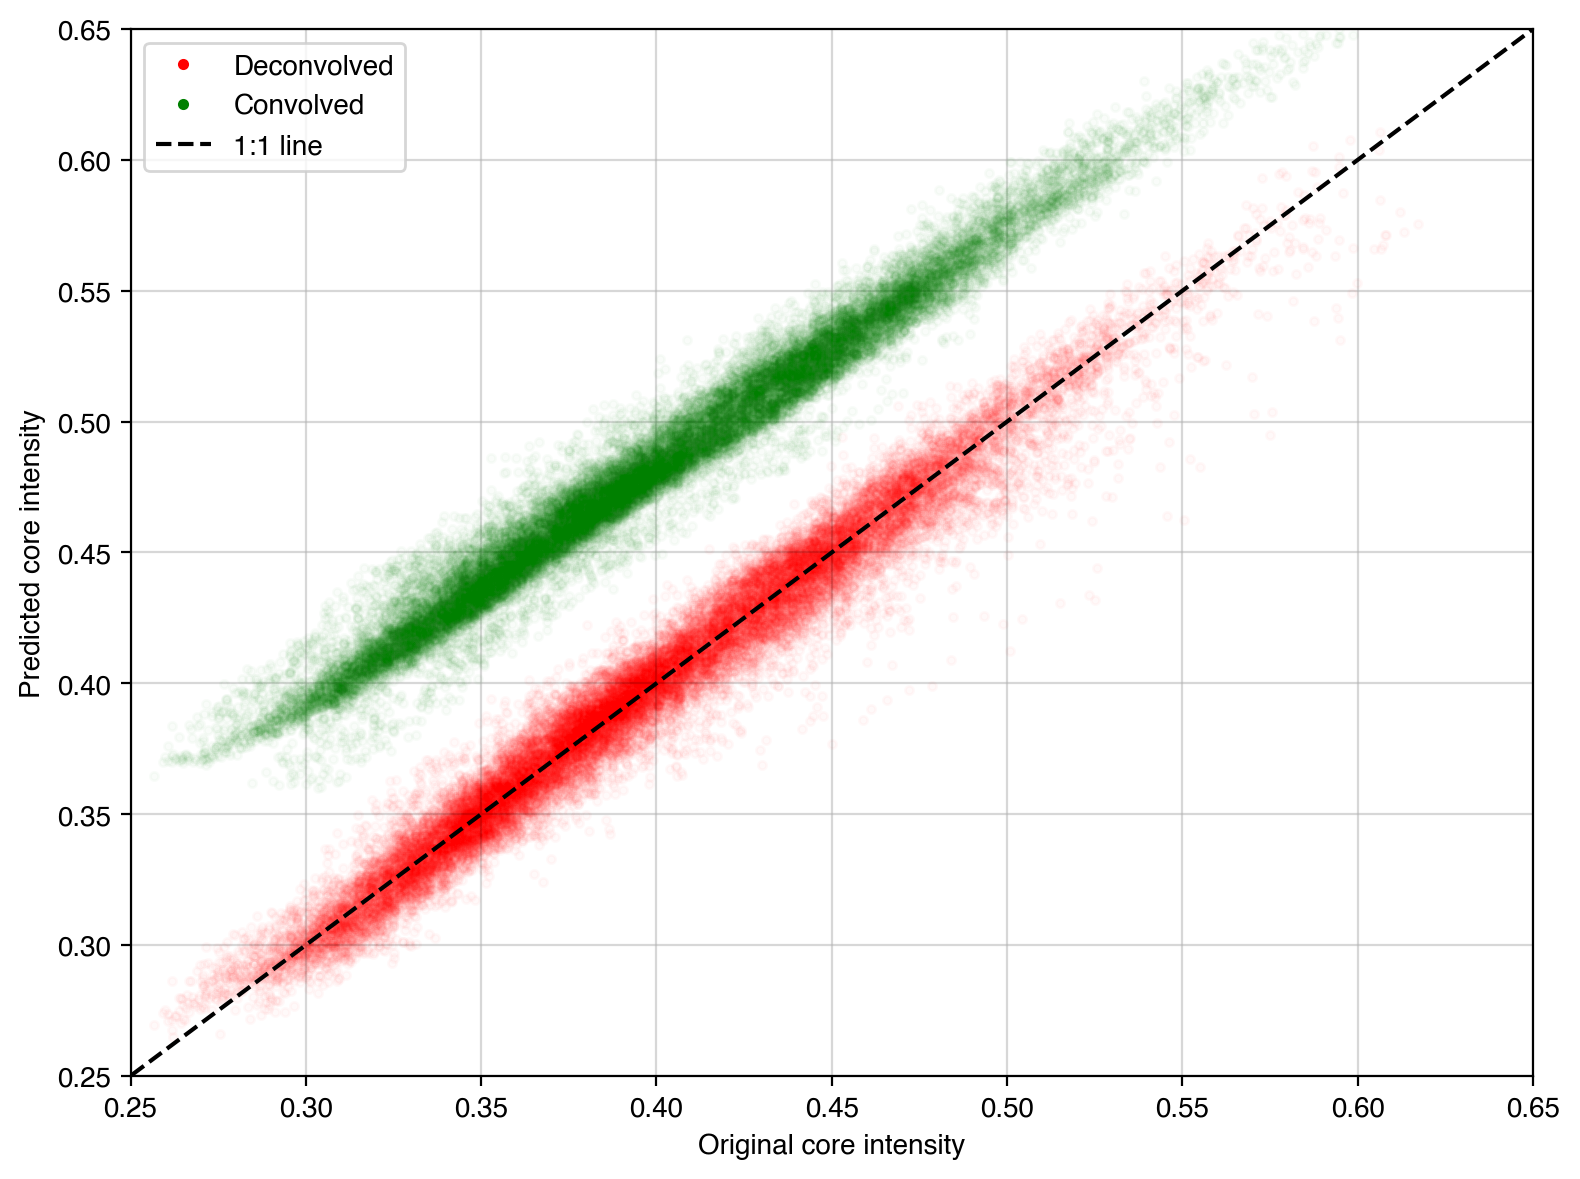

In [204]:
fSizeAxisLabel = 10

caData_test = load_spectral_profiles('', 'FISS_20160622_174907_B1.fts')

caConvolved_test = np.zeros((Nx_ca,Ny_ca, 502))
 
TProfile = produce_FP_transmission_peak(caSpectralRes, 0, Nlambda_ca, 2, 6563)

TProfile[0:140] = 0
TProfile[360:] = 0
TProfile = TProfile / np.sum(TProfile)
ax[0, 0].plot(TProfile)
    

for ii in range(Nx_ca):
    for jj in range(Ny_ca):
        caConvolved_test[ii, jj, :] = np.convolve(caData_test[ii, jj, :], TProfile, mode='same')
        
caConvolved_test = np.reshape(caConvolved_test, (Nx_ca*Ny_ca, 502, 1))
caData_test      = np.reshape(caData_test, (Nx_ca*Ny_ca, 502))

caData_test1      = caData_test[:, lStart:lEnd]
caConvolved_test1 = caConvolved_test[:, lStart:lEnd, :]

#plt.plot(caData_test1[200,:]/norm_conv)
#plt.plot(caConvolved_test[200,:,0]/norm_conv)
#plt.show()
print(norm_conv)
evaluation = model1.evaluate(np.reshape(caData_Conv_norm, (int(Nx_ca*Ny_ca), dl, 1)),
                            np.reshape(caData_norm, (int(Nx_ca*Ny_ca), dl)))

evaluation = model1.evaluate(caConvolved_test1/norm_conv, caData_test1/norm_data, verbose=1)

start = time.process_time()

predict    = model1.predict(caConvolved_test1/norm_conv,verbose=1)
print("The elapsed time for 1M Pixel inversion is: %6.2f seconds"%(time.process_time() - start))
print(predict.shape)
m.rcParams.update({'font.sans-serif':'Helvetica'})
csfont = {'fontname':'Helvetica'}

wavex = np.linspace(np.amin(predict)-.05,np.amax(predict),num=1000)


plt.figure(dpi=200,figsize=(8,6))
plt.xlim(0.25, 0.65)
plt.ylim(0.25, 0.65)

plt.plot(np.amin(caData_test1/norm_conv,axis=1), np.amin(predict,axis=1), 'r.'
         ,alpha=0.022)
plt.plot(0,0,'r.',label='Deconvolved')
plt.plot(np.amin(caData_test1/norm_conv,axis=1),np.amin(caConvolved_test1/norm_conv,axis=1)
         ,'g.',alpha=0.022)
plt.plot(0,0,'g.',label='Convolved')
plt.plot(wavex,wavex,'k--',label='1:1 line')

np.savez('Fig2_3.npz', caData_test1, norm_conv, predict, caConvolved_test1, wavex)

plt.xlabel('Original core intensity', **csfont, fontsize = fSizeAxisLabel)
plt.ylabel('Predicted core intensity', **csfont, fontsize = fSizeAxisLabel)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('Figures/Linecore_int_int.png',transparent=True)
plt.show()

237 277
235 280
(25000, 0)


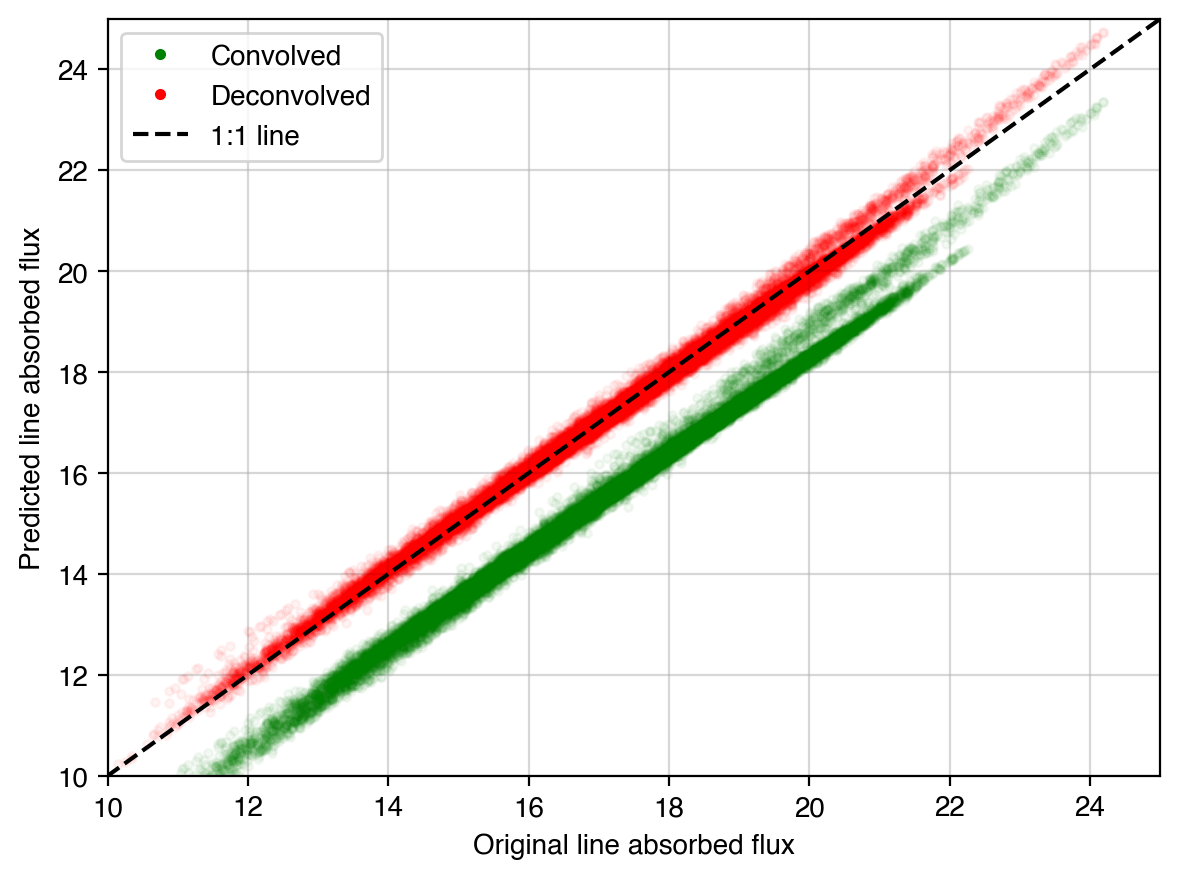

In [205]:
print(lStart1,lEnd1)
print(lStart,lEnd)
print(caData_test1[:,lStart1:lEnd1].shape)

x_min = 10
x_max = 25

m.rcParams.update({'font.sans-serif':'Helvetica'})
csfont = {'fontname':'Helvetica'}
wavex = np.linspace(0,200,num=1000)
plt.figure(dpi=200,figsize=(6,4.5))
plt.xlim(x_min,x_max)
plt.ylim(x_min,x_max)

plt.plot(45-np.sum(caData_test1/norm_conv,axis=1), 45-np.sum(predict,axis=1),
         'r.', alpha=0.042)

plt.plot(45 - np.sum(caData_test1/norm_conv,axis=1),
         45 - np.sum(caConvolved_test1/norm_conv,axis=1), 'g.', alpha=0.042)

plt.plot(0, 0, 'g.', label='Convolved')
plt.plot(0, 0, 'r.', label='Deconvolved')

plt.plot(wavex, wavex, 'k--', label='1:1 line')


plt.xlabel('Original line absorbed flux',**csfont,fontsize = fSizeAxisLabel)
plt.ylabel('Predicted line absorbed flux',**csfont,fontsize = fSizeAxisLabel)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('Figures/Linecore_flux_flux.png',transparent=True)
plt.show()

In [549]:
caDataHDU = fits.PrimaryHDU(caData_test1/norm_conv)
caDataHDU.writeto('caData_original.fits')

caDataConvHDU = fits.PrimaryHDU(caConvolved_test1/norm_conv)
caDataConvHDU.writeto('caData_Conv.fits')
 
resHDU   = fits.PrimaryHDU(predict)
resHDU.writeto('caData_res.fits')

## Convolve with a multi-peak PSF and try to reproduce the line profile

In [523]:
caData_Conv_norm.shape

(100, 250, 45)

100 250


NameError: name 'color2' is not defined

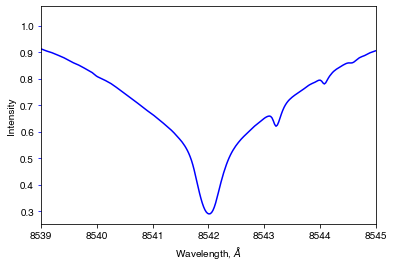

In [47]:
Nlambda      = 200
dlambda      = 0.024
trans_filter = produce_FP_transmission_peak(caSpectralRes,0,Nlambda,1,8542)
trans_filter = trans_filter / np.sum(trans_filter)
wave         = np.linspace(-.5*Nlambda*dlambda,.5*Nlambda*dlambda,num=Nlambda)+8542.
wave502      = np.linspace(502*dlambda/(-2),502*dlambda/2,num=502)+8541.9


 
lStart1 = lStart + 2
lEnd1   = lStart + 42
dl1 = lEnd1 - lStart1
print(Nx_ca,Ny_ca)

fig1, ax1 = plt.subplots()
color1 = 'blue'
fig1.set_dpi=400
fig1.set_size_inches(6,4)
ax1.plot(wave502,np.mean(caData,axis=(0,1))/7000,label='Average spectrum',color=color1)
ax1.tick_params(axis='y',color=color1)
ax1.set_xlabel('Wavelength, $\\AA$')
ax1.set_ylabel('Intensity')
ax1.set_xlim(8542-3,8542+3)
ax1.plot(0,0,'-',color=color2,label='Transmission profile')
ax1.grid(alpha=0.5)

ax2 = ax1.twinx() 
color2 = 'deeppink'
ax2.set_ylabel('Transmissivity', color=color2)
ax2.plot(wave,trans_filter,color=color2,label='Transmission profile')
ax2.tick_params(axis='y', labelcolor=color2)
ax1.legend(loc=2)
fig1.tight_layout()
fig1.savefig('Figures/Multiplex_2.png',transparent=True)
plt.show()
plt.close()


caConvolvedMP = np.zeros((Nx_ca*Ny_ca,int(dl1/2),1))
plt.imshow(caData[:,:,240])
plt.show()
caData1       = np.reshape(caData,(Nx_ca*Ny_ca,502))

for ii in range(Nx_ca*Ny_ca):
    caConvolvedMP[ii,:,0] = (np.convolve(caData1[ii,:],trans_filter,mode='same'))[lStart1:lEnd1:2]

print(caConvolvedMP.shape)
plt.plot(caConvolvedMP[2301,:])
plt.plot(caData1[2301,lStart1:lEnd1])
plt.show()

In [663]:
modelMP = build_conv_model_MP(2)
modelMP.summary()

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 20, 1)]           0         
_________________________________________________________________
conv1d_244 (Conv1D)          (None, 18, 5)             20        
_________________________________________________________________
max_pooling1d_77 (MaxPooling (None, 9, 5)              0         
_________________________________________________________________
conv1d_245 (Conv1D)          (None, 7, 10)             160       
_________________________________________________________________
conv1d_246 (Conv1D)          (None, 5, 20)             620       
_________________________________________________________________
up_sampling1d_108 (UpSamplin (None, 10, 20)            0         
_________________________________________________________________
conv1d_247 (Conv1D)          (None, 8, 20)             122

In [668]:
EPOCHS = 10000
#print(train_set)

optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    modelMP.optimizer = tf.keras.optimizers.Adam(lr=1e-1, beta_1=0.9,
              beta_2=0.999, epsilon=1e-8, decay=1.0, amsgrad=False)
if optimizer == 'SGD': 
    modelMP.optimizer = tf.keras.optimizers.SGD(lr=1e-2, nesterov=True)

history = modelMP.fit((caConvolvedMP-3000)/2000,caData1[:,lStart1:lEnd1]/4000,
                      epochs=EPOCHS,validation_split=0.15 , verbose=2)


Train on 21250 samples, validate on 3750 samples
Epoch 1/1000
21250/21250 - 4s - loss: 0.0083 - mean_absolute_error: 0.0607 - mean_squared_error: 0.0058 - val_loss: 0.0077 - val_mean_absolute_error: 0.0586 - val_mean_squared_error: 0.0055
Epoch 2/1000
21250/21250 - 4s - loss: 0.0083 - mean_absolute_error: 0.0607 - mean_squared_error: 0.0058 - val_loss: 0.0077 - val_mean_absolute_error: 0.0586 - val_mean_squared_error: 0.0055
Epoch 3/1000
21250/21250 - 4s - loss: 0.0083 - mean_absolute_error: 0.0607 - mean_squared_error: 0.0058 - val_loss: 0.0077 - val_mean_absolute_error: 0.0587 - val_mean_squared_error: 0.0055
Epoch 4/1000
21250/21250 - 4s - loss: 0.0083 - mean_absolute_error: 0.0607 - mean_squared_error: 0.0058 - val_loss: 0.0077 - val_mean_absolute_error: 0.0586 - val_mean_squared_error: 0.0055
Epoch 5/1000
21250/21250 - 4s - loss: 0.0083 - mean_absolute_error: 0.0607 - mean_squared_error: 0.0058 - val_loss: 0.0077 - val_mean_absolute_error: 0.0586 - val_mean_squared_error: 0.0055
E

KeyboardInterrupt: 

(100, 250, 45)
(25000, 20, 1)


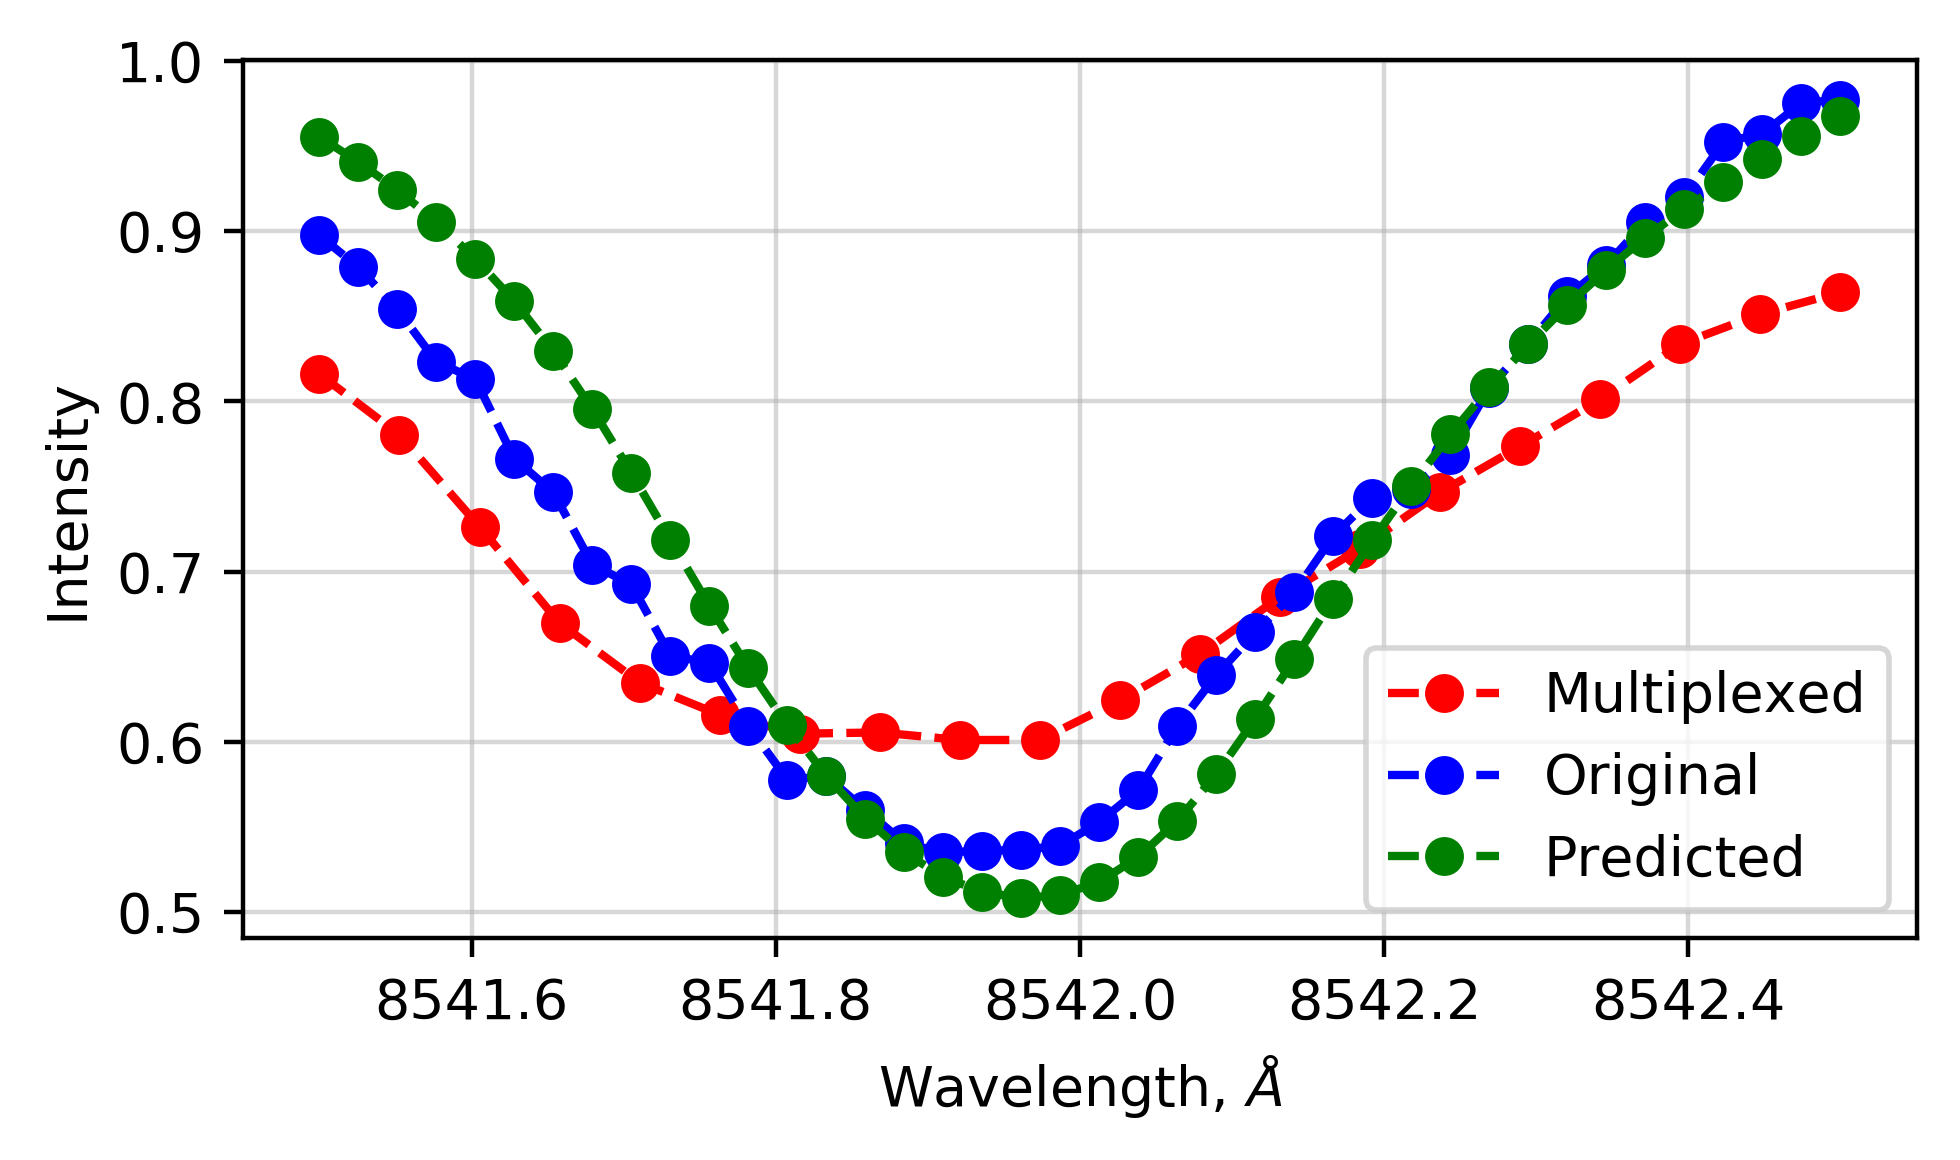

In [696]:
prevNum  = 9000
delta    = 1
#im       = model.predict(train_set[:,:,:])
#plt.figure(dpi=200)
#plt.imshow(np.reshape(train_set[:,30,0],(968,968)))
#plt.show()
#plt.figure(dpi=200)Z
#plt.imshow(np.reshape(im[:,30],(968,968)))
#plt.show()
#plt.figure(dpi=200)
#plt.imshow(np.reshape(truth_set[:,30],(968,968)))
#plt.show()
dlambda1     = 0.025
markersizex  = 12
print(caData_Conv_norm.shape)
res = modelMP.predict(caConvolvedMP[prevNum:prevNum+delta]/5000)

wavescale  = np.linspace(-10*dlambda1*2+8542.0,10*dlambda1*2+8542.0,num=40)
print(caConvolvedMP.shape)
wavescale1 = np.linspace(-10*dlambda1*2+8542.0,10*dlambda1*2+8542.0,num=20)
#plot_spec_profile_comparison(wavescale,caConvolvedMP[prevNum:prevNum,:]/5000,
                            #caData1[prevNum:prevNum,::2]/5000,res[0,0:-1:2])
plt.figure(dpi=400,figsize=(5,3))

plt.plot(wavescale1,(caConvolvedMP[prevNum,:,0]-3000)/2000,'r--.',label='Multiplexed',markersize = markersizex)
plt.plot(wavescale,caData1[prevNum,lStart1:lEnd1]/4000,'b--.',label='Original',markersize = markersizex)
plt.plot(wavescale,res[0,:],'g--.',label='Predicted',markersize = markersizex)
plt.grid(alpha=0.5)
plt.xlabel('Wavelength, $\\AA$')
plt.ylabel('Intensity')
plt.legend()
plt.tight_layout()
plt.savefig('Figures/MP_fail.png',transparent = True)
plt.show()

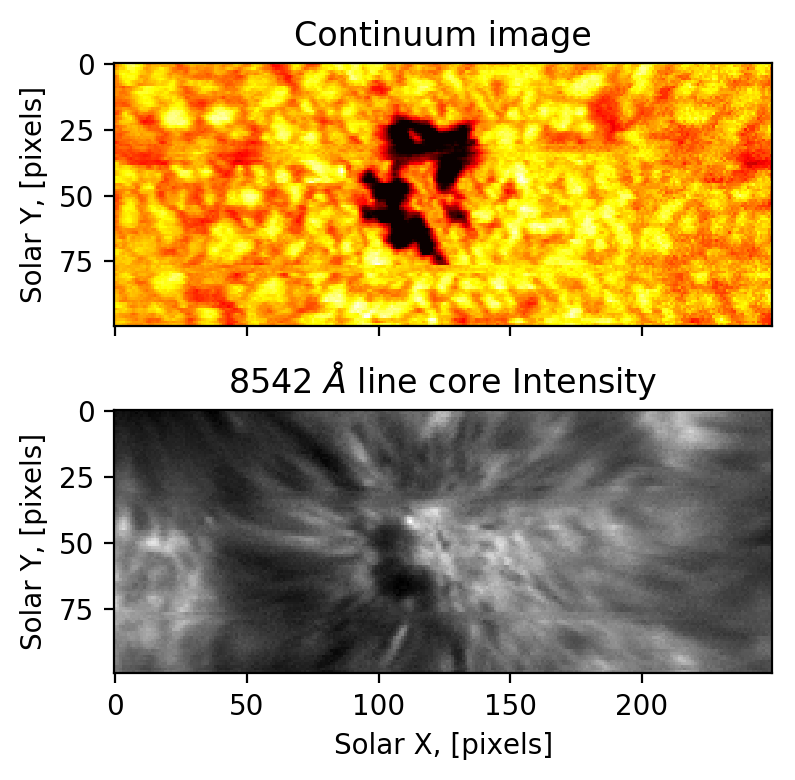

In [704]:
cont_index = 1
core_index = 256

fig, ax = plt.subplots(2,1)
fig.set_dpi(200)
fig.set_size_inches(6,4)
ax[0].imshow(caData[:,:,cont_index],cmap='hot',
             vmax=np.amax(caData[:,:,cont_index]),vmin=np.amin(caData[:,:,cont_index])*1.3)
ax[0].set_title('Continuum image')
ax[0].set_xticklabels([])
ax[0].set_ylabel('Solar Y, [pixels]')

ax[1].imshow(caData[:,:,core_index],cmap='gray',
             vmax=np.amax(caData[:,:,core_index]),vmin=np.amin(caData[:,:,core_index])*1.)
ax[1].set_title('8542 $\\AA$ line core Intensity')
ax[1].set_xlabel('Solar X, [pixels]')
ax[1].set_ylabel('Solar Y, [pixels]')

plt.tight_layout()

plt.savefig('Figures/FISS_FOV.png',transparent=True)
plt.show()

TProfile dimensions are (22,)


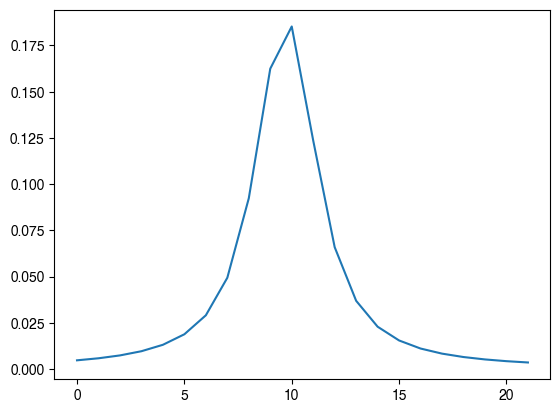

shape of caData is (100, 250, 502)
shape of caConvolved is (100, 250, 502)
The elapsed time for 25000 inversion is 6.2230970000000525


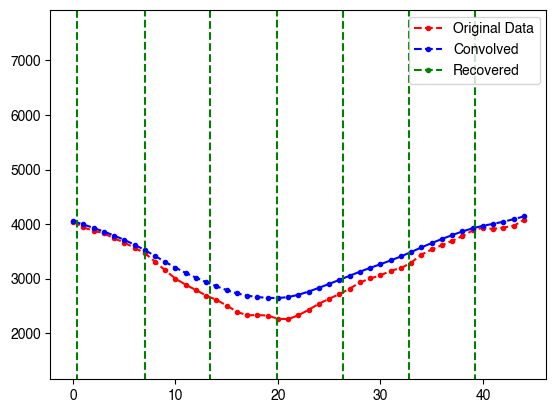

In [165]:
# TProfile -- transmission profile
# caConvolved[80, 20, lStart:lEnd]
# caData[80, 20, lStart:lEnd]

minTP = np.amin(TProfile)
TProfile_min = TProfile[240:-240]
print(f"TProfile dimensions are {TProfile_min.shape}")
for ii in range(len(TProfile_min)):
    if TProfile_min[ii] == 0:
        TProfile_min[ii] = 1e-3

plt.plot(TProfile_min)
plt.show()
        
print(f'shape of caData is {caData.shape}')
print(f'shape of caConvolved is {caConvolved.shape}')
plt.plot(caData[80, 20, lStart:lEnd], 'r.--', label='Original Data')
plt.plot(caConvolved[80, 20, lStart:lEnd], 'b.--', label='Convolved')

N_trials = 25000
start = time.process_time()
for ii in range(250):
    for jj in range(100):
        recovered, remainder = deconvolve(caConvolved[jj, ii, :], TProfile_min)
print(f"The elapsed time for {N_trials} inversion is {time.process_time() - start}")

plt.plot(recovered[lStart:lEnd], 'g.--', label='Recovered')
plt.ylim(np.amin(caConvolved[jj, ii, lStart:lEnd])*.5, np.amax(caConvolved[jj, ii, lStart:lEnd])*2)
plt.legend()
plt.show()


The elapsed time for 250 inversion is 1.9011200000004465


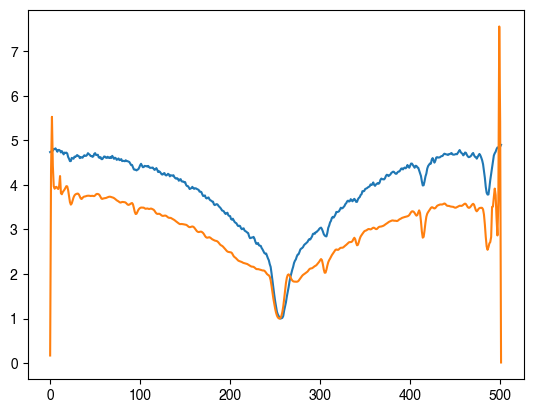

In [185]:
from skimage import color, data, restoration
TProfile_multiD = np.zeros((10, 25, 22))
for ii in range(10):
    for jj in range(25):
        TProfile_multiD[ii, jj, :] = TProfile_min[:]
start = time.process_time()
DL = restoration.richardson_lucy(caData[0:10, 0:25, :], TProfile_multiD, iterations=30)
print(f"The elapsed time for 250 inversion is {time.process_time() - start}")

plt.plot(caData[8,8,:]/np.amin(caData[8,8,100:300]))
plt.plot(DL[8,8,:]/np.amin(DL[8,8,100:300]))
plt.show()